In [7]:
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parse_results import *
from utils.utils import *
from db_utils.utils import *
from db_utils.query_storage import *
import networkx as nx
from cardinality_estimation.algs import *
import numpy as np
from cardinality_estimation.losses import *
#from cardinality_estimation.join_loss import JoinLoss, get_join_cost_sql, get_leading_hint
from cardinality_estimation.join_loss import *
from cardinality_estimation.nn import update_samples

from sql_rep.utils import nodes_to_sql, path_to_join_order
import cvxpy as cp
import time
import copy
from multiprocessing import Pool
from scripts.analyze_query import QUAD_BETAS
# FIXME: separate jupyter utils files especially for plotting utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
COST_MODEL = "cm1"
COST_KEY = COST_MODEL + "cost"


QUERY_DIR = "./debug_sqls/"
query = "2.pkl"

qfn = QUERY_DIR + query
postgres = Postgres()
true_alg = TrueCardinalities()

USER = "pari"
PWD = ""
HOST = "localhost"
PORT = 5432
DB_NAME = "imdb"
SAVE_DIR = "./QueryLabPlots/"

# for join loss computations

QUERY_ERRORS_DATA_FN = "all_subquery/" + query + "/query_data.pkl"

In [3]:
# qrep = load_sql_rep(qfn)
# join_graph = qrep["join_graph"]
# subset_graph = qrep["subset_graph"]
# sql = qrep["sql"]
# print(sql)
#update_samples([qrep], 0, COST_MODEL, 1)

In [4]:
# nx.draw(join_graph, pos=nx.circular_layout(join_graph), with_labels=True, node_size=2000, font_size=24)
# plt.savefig(SAVE_DIR + "join_graph.png")

In [5]:
assert os.path.exists(QUERY_ERRORS_DATA_FN)
data = load_object(QUERY_ERRORS_DATA_FN)
subsets = list(data.keys())[0]
flow_plan_errs = list(zip(*data[str(subsets)][-2]))
print(flow_plan_errs[1])
print(set(flow_plan_errs[1]))
quad_errs = data[str(subsets)][-4]
#print(quad_errs)
flow_plans = list(zip(*data[str(subsets)][-1]))
print(flow_plans[1][0]) 
print(flow_plans[1][5])

for k,v in data.items():
    for i,err in enumerate(v):
        print(i, len(err))

(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

perturb_plots/2.pkl/
num subsets:  17


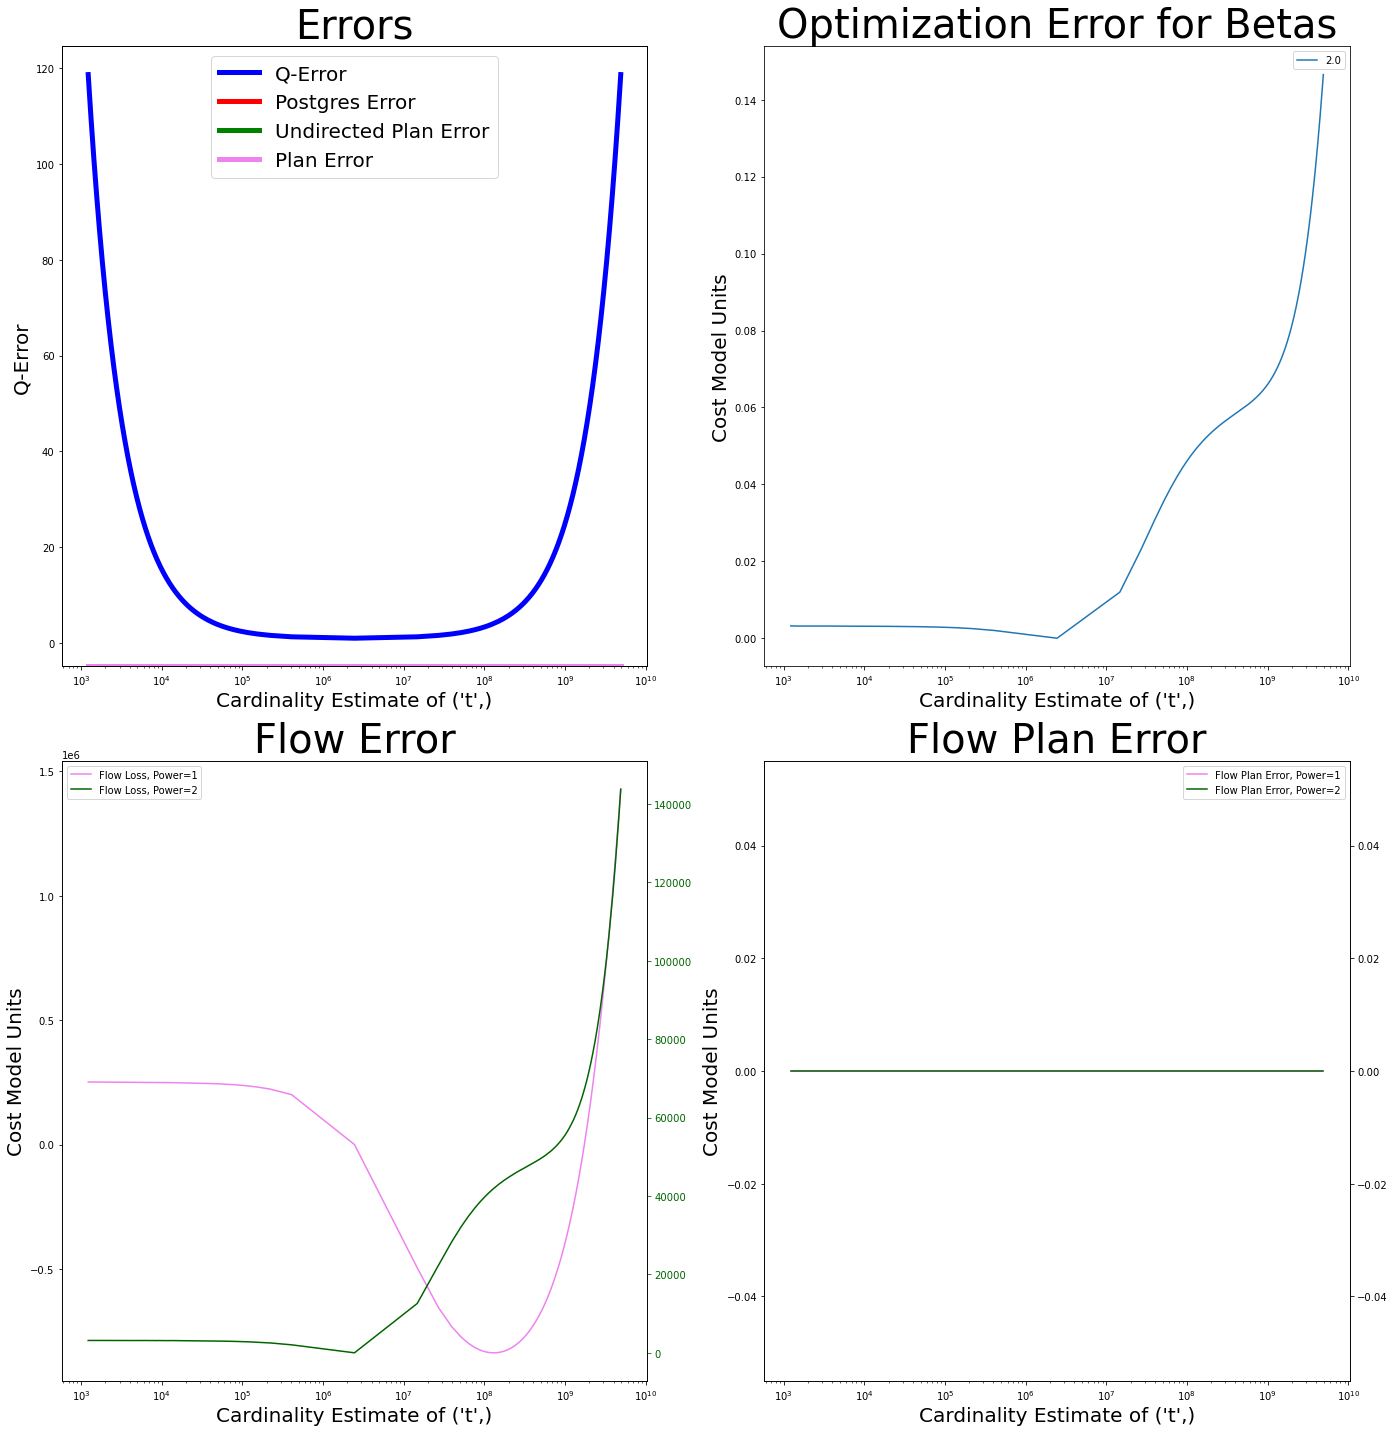

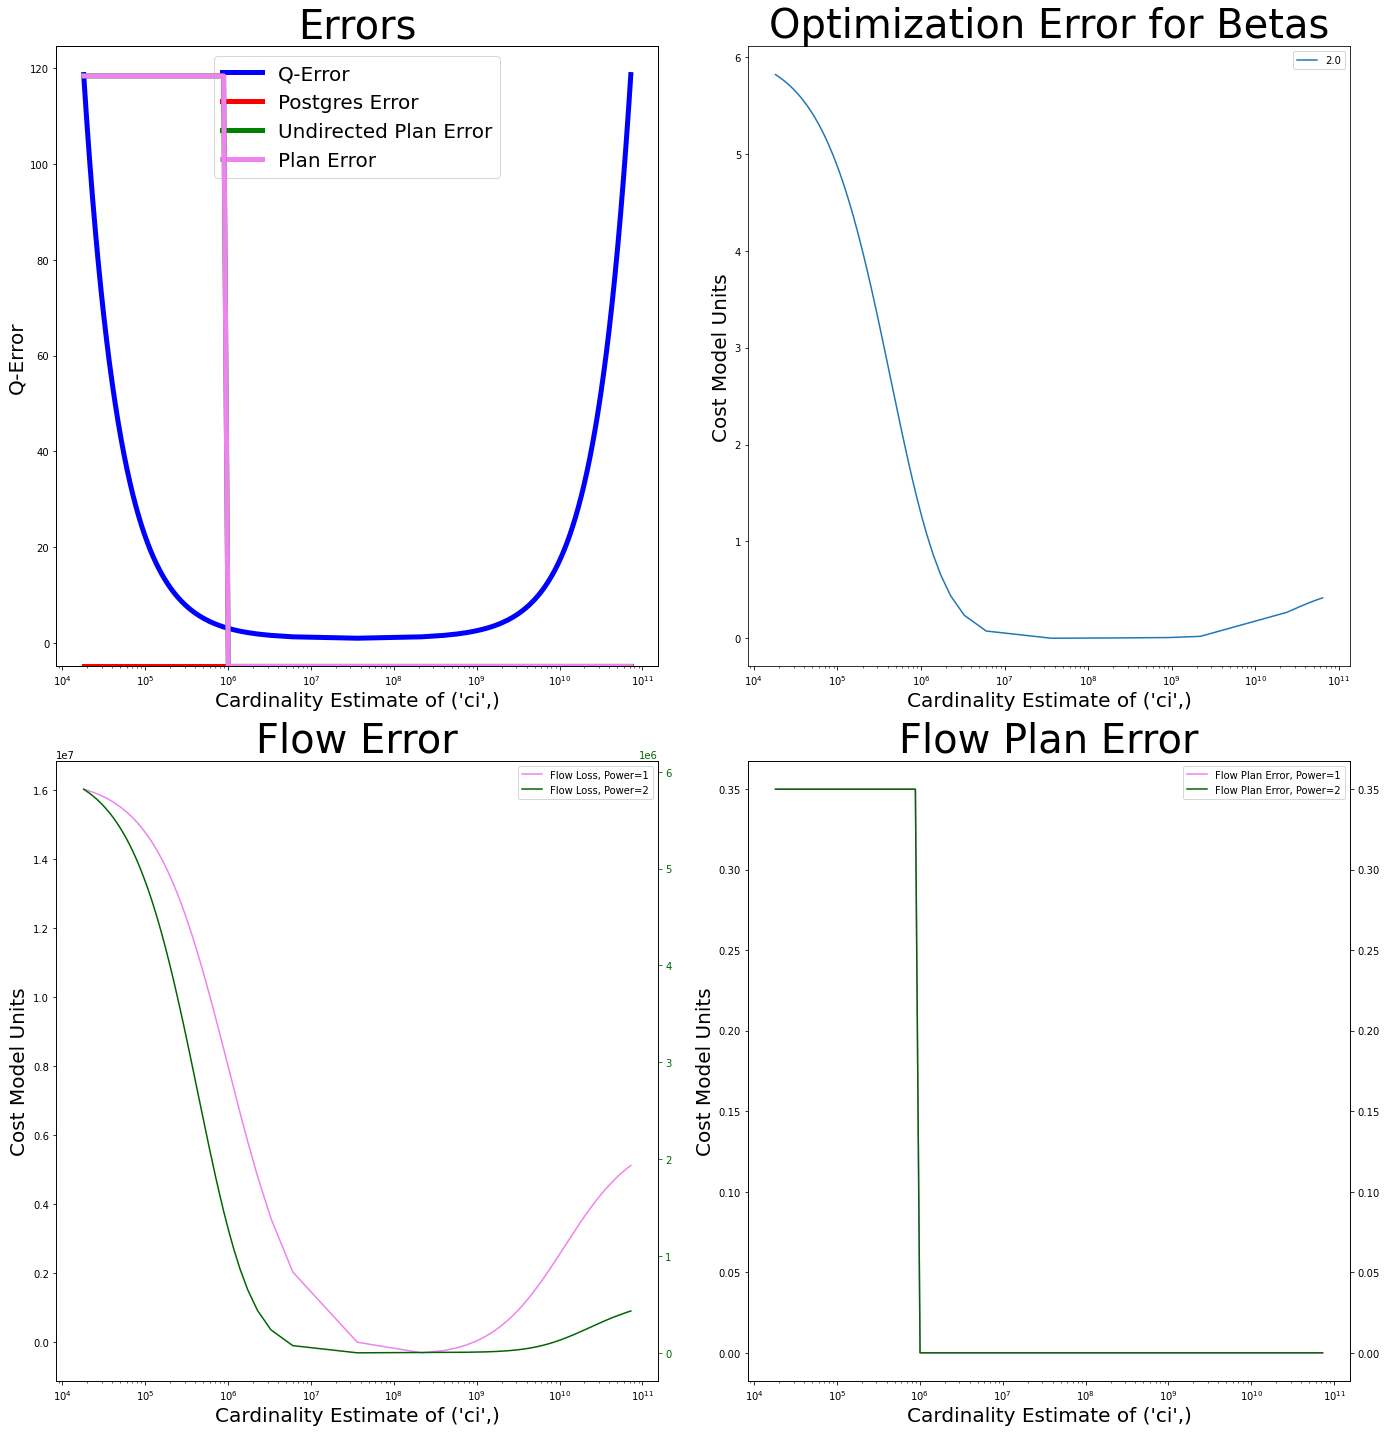

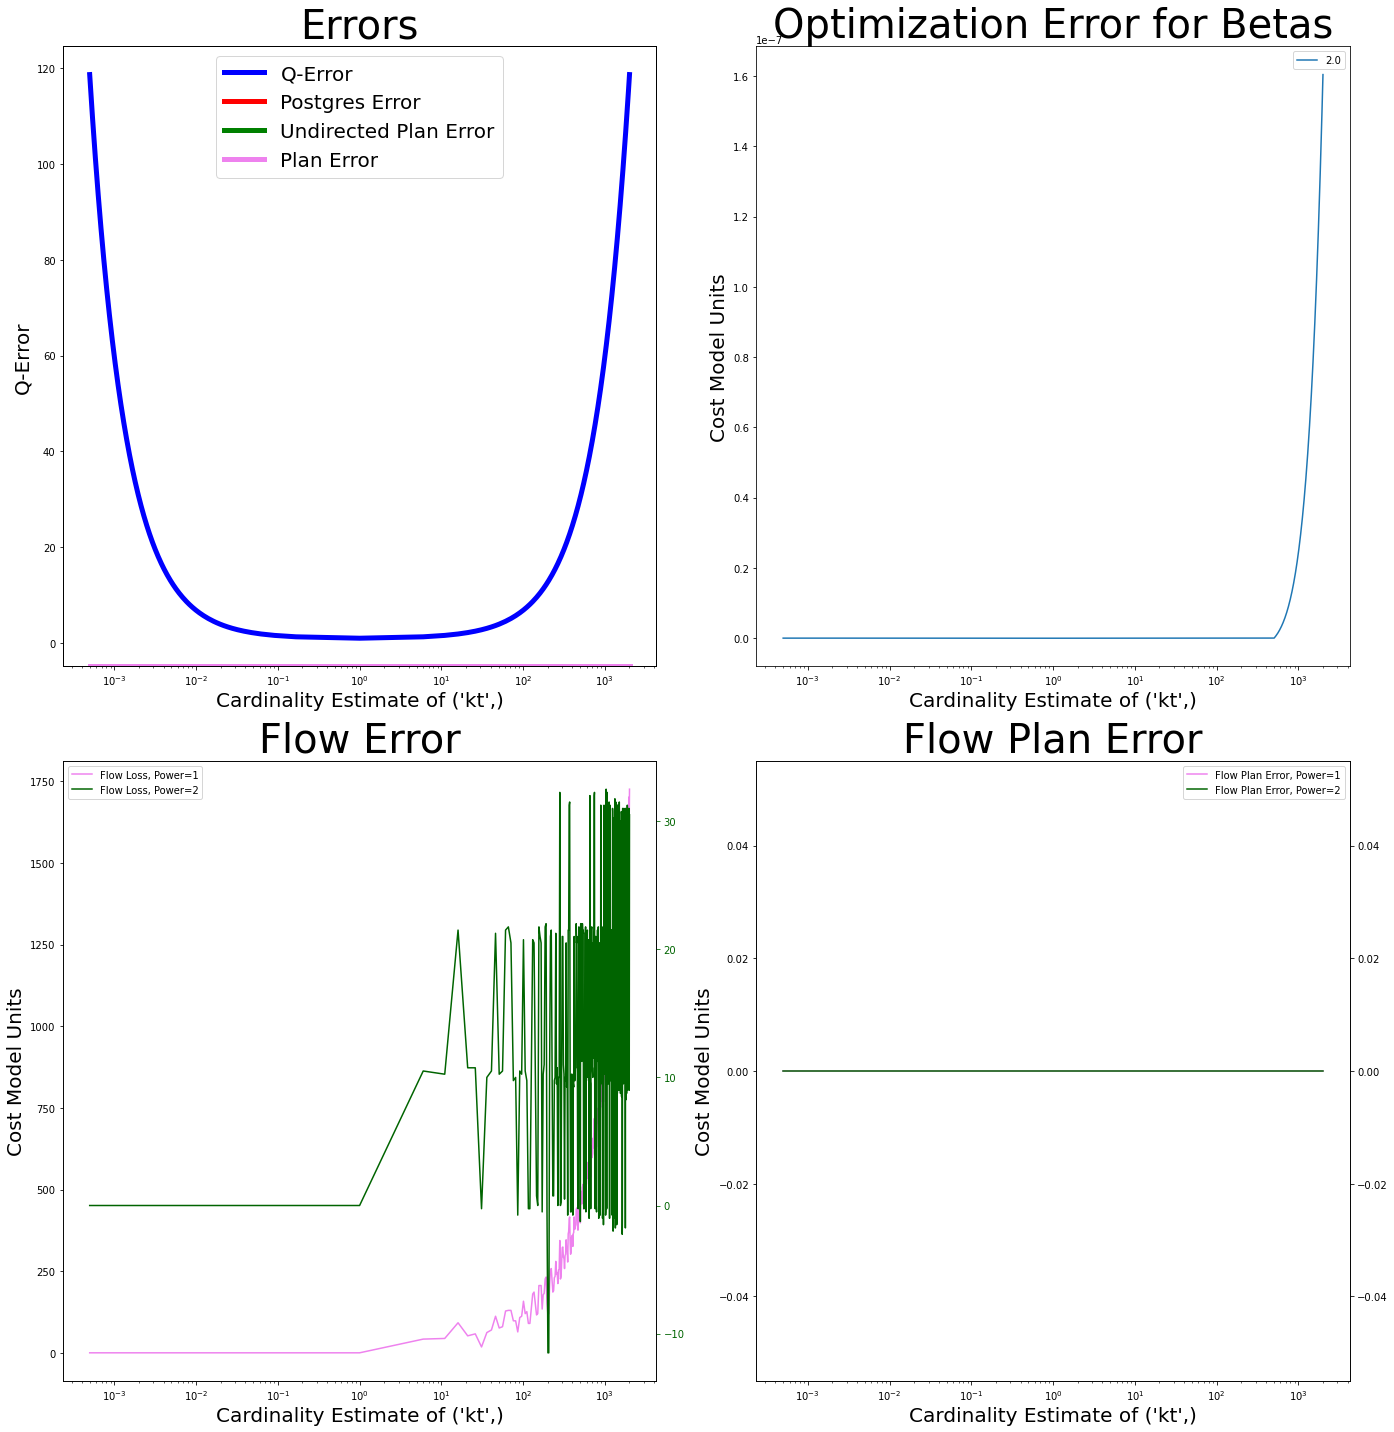

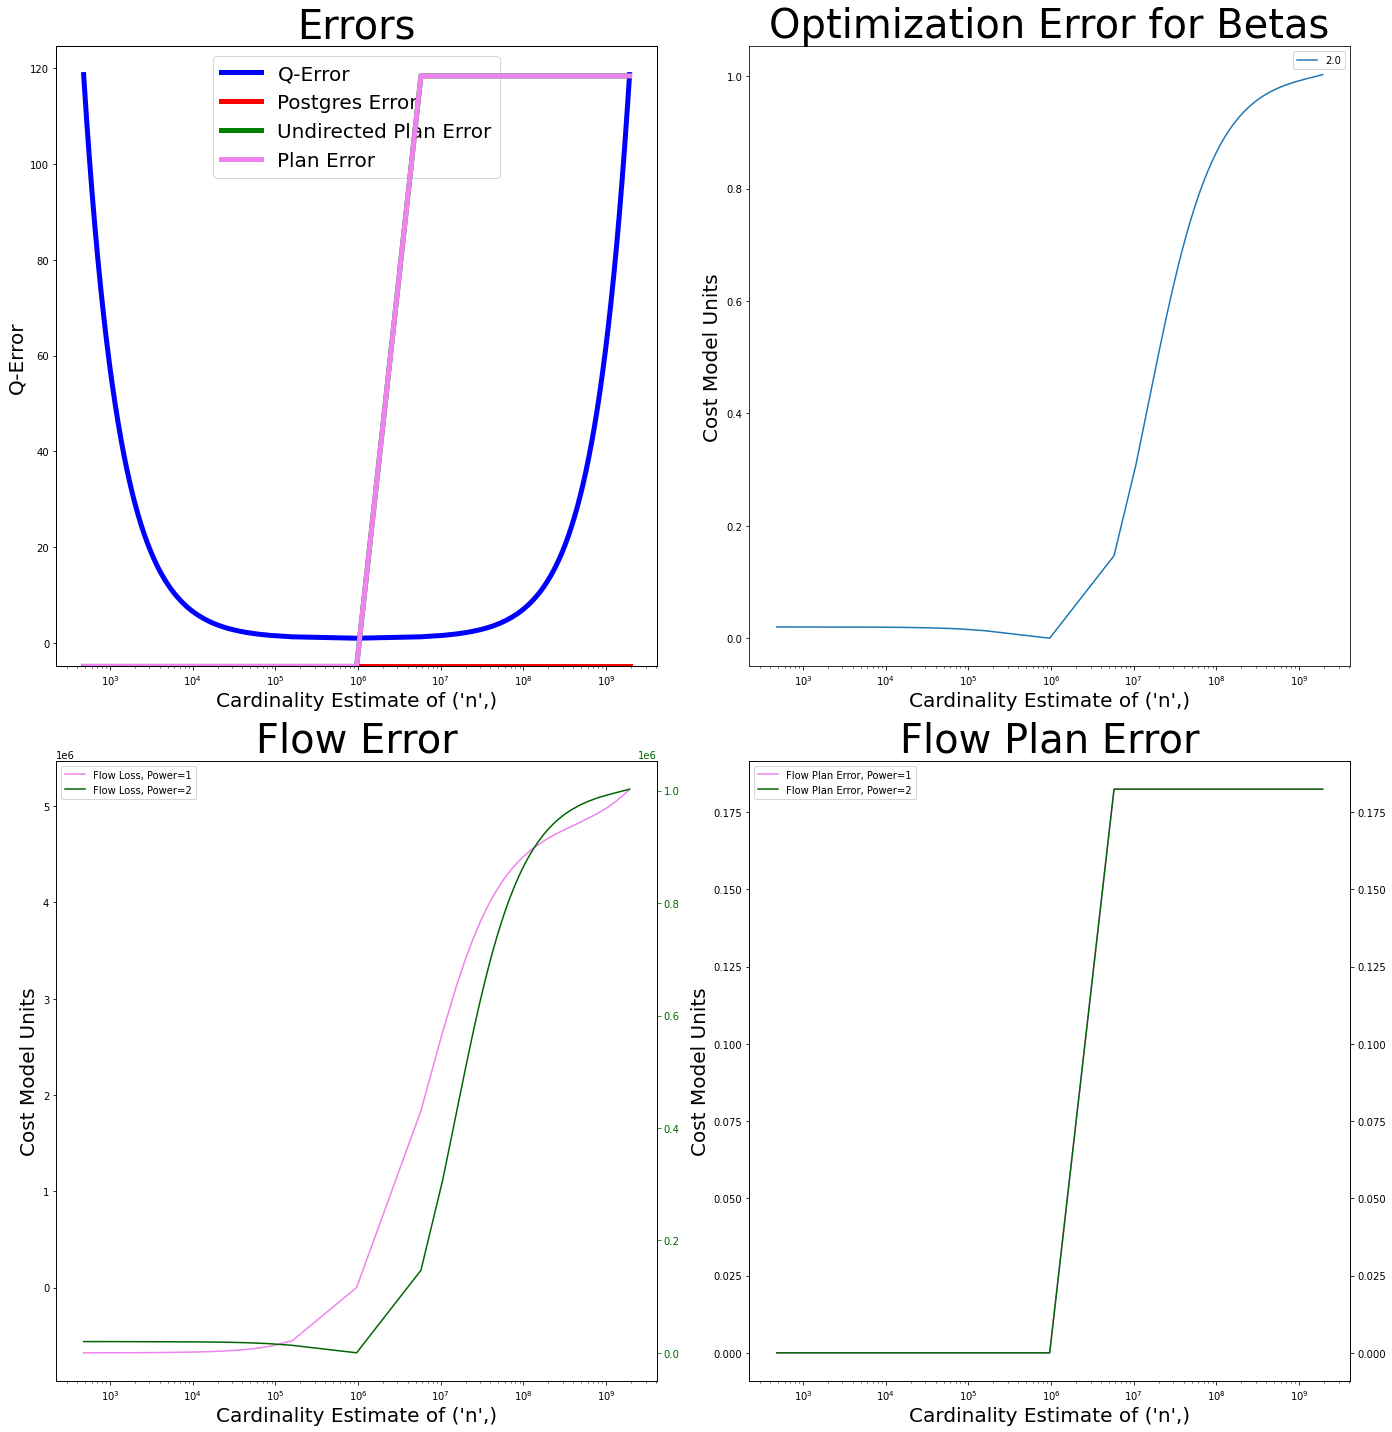

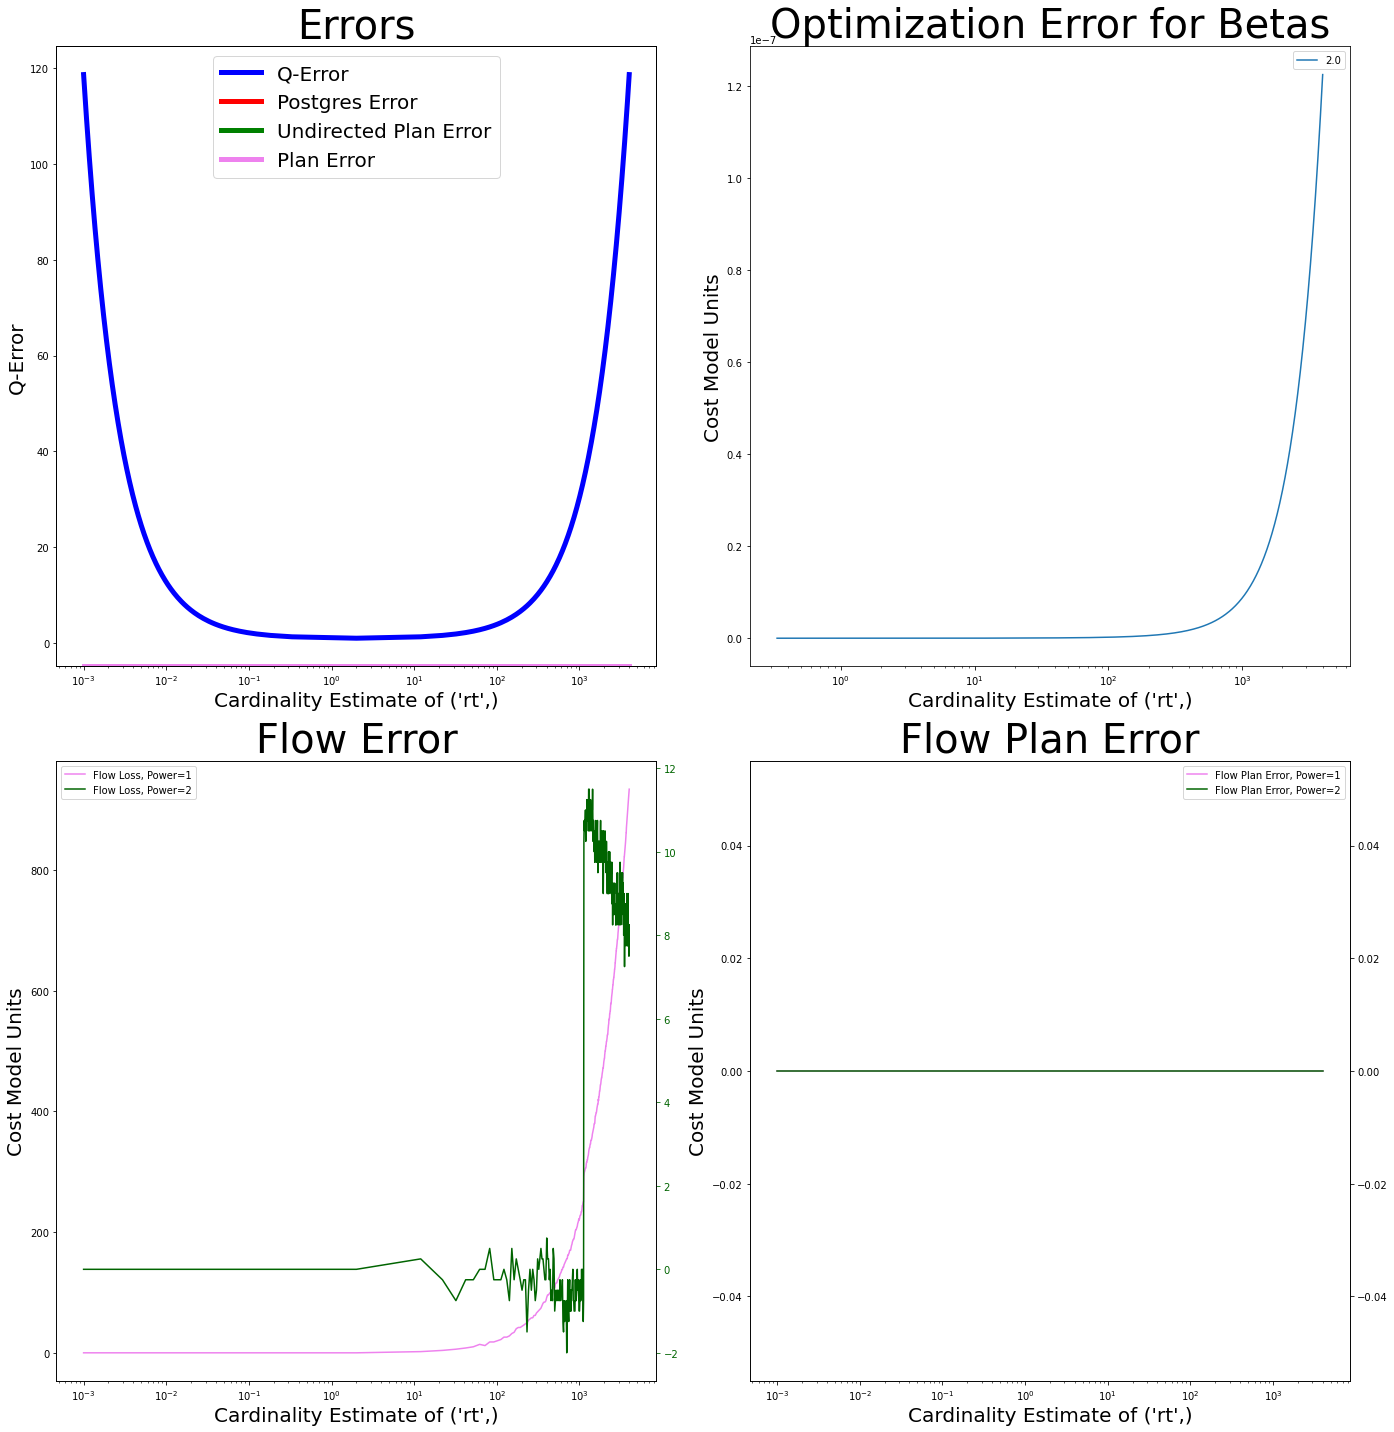

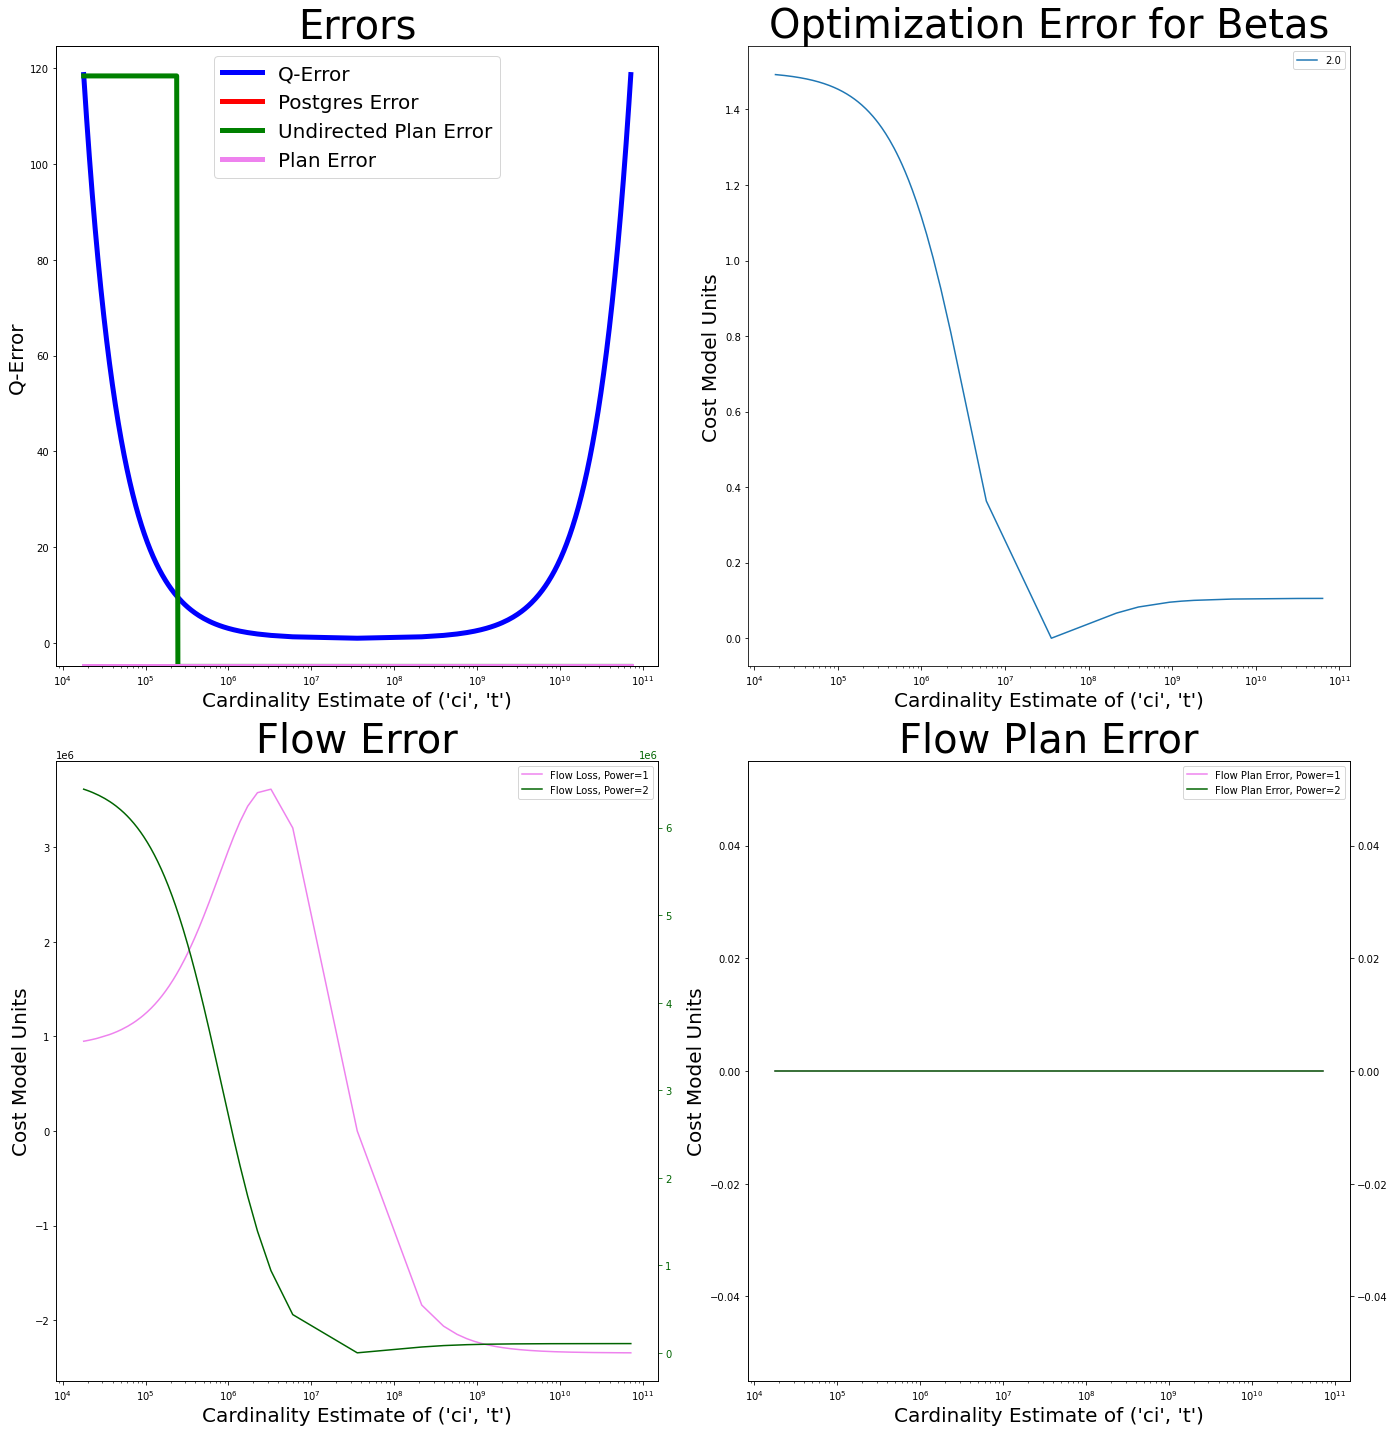

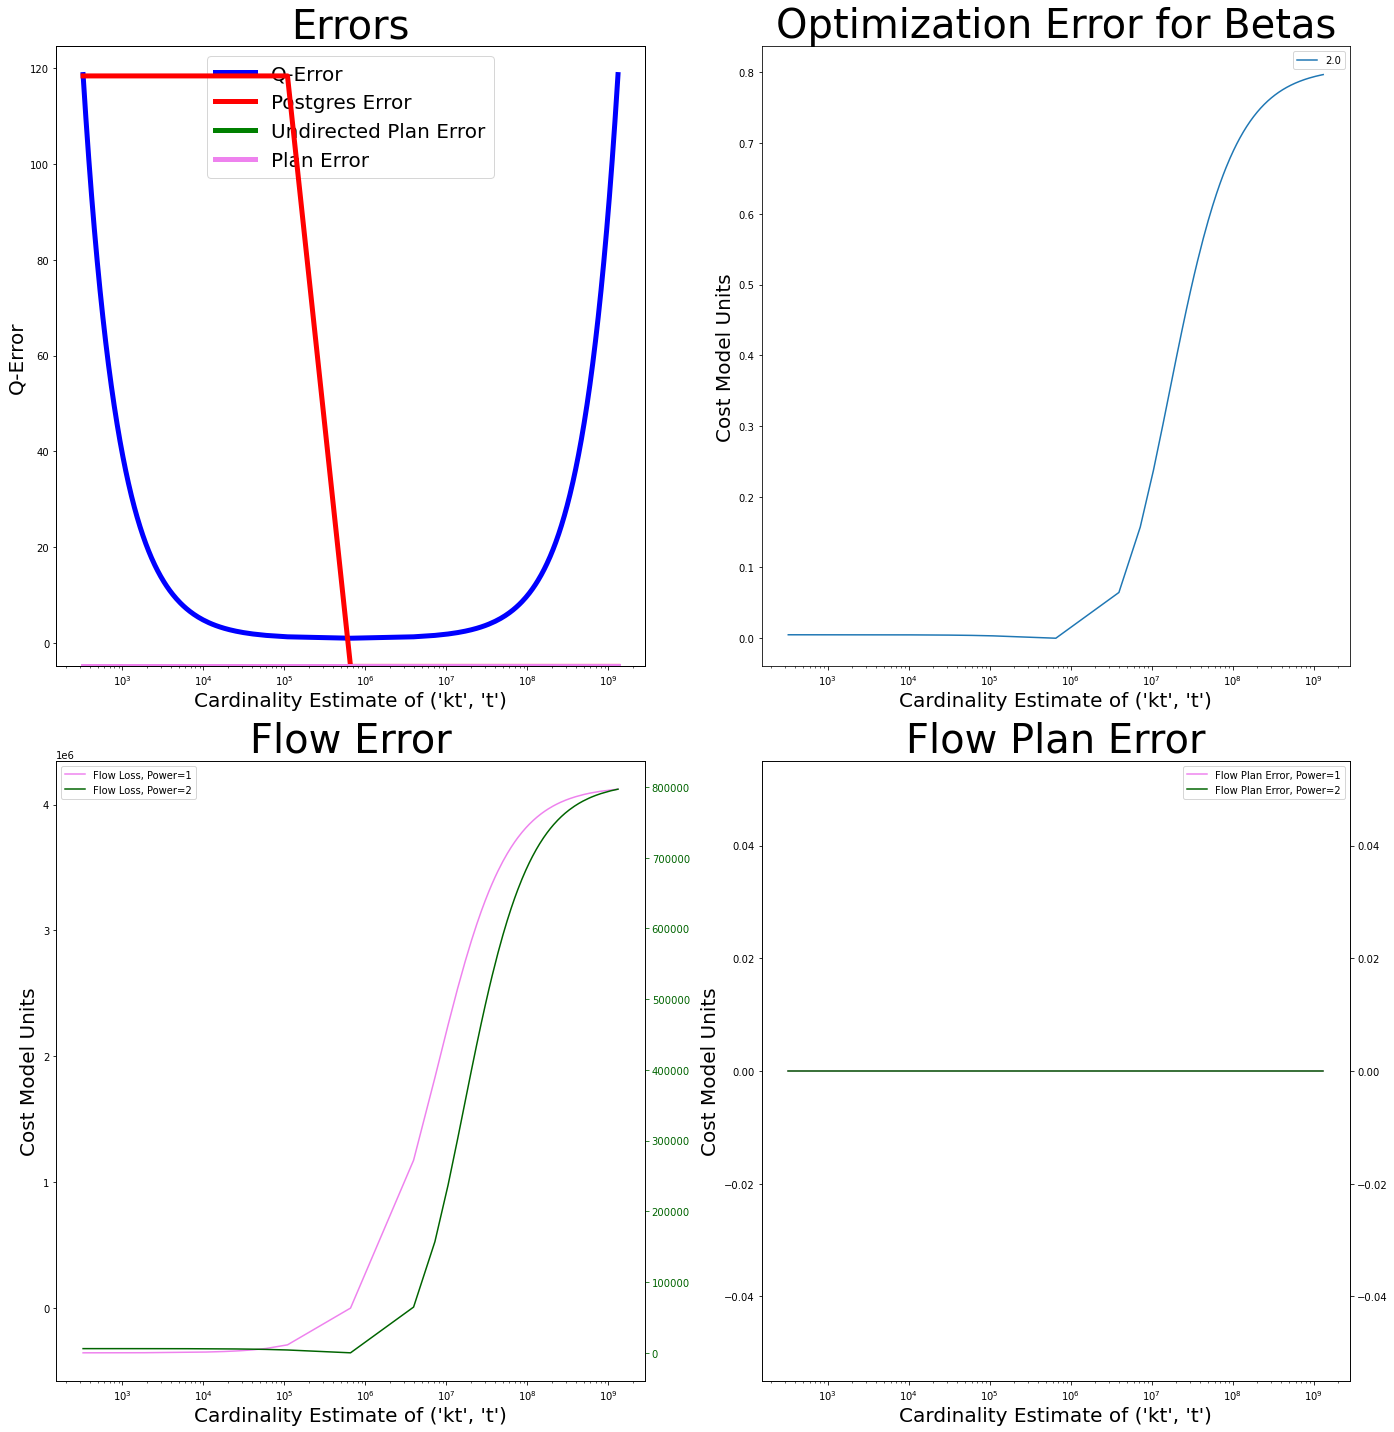

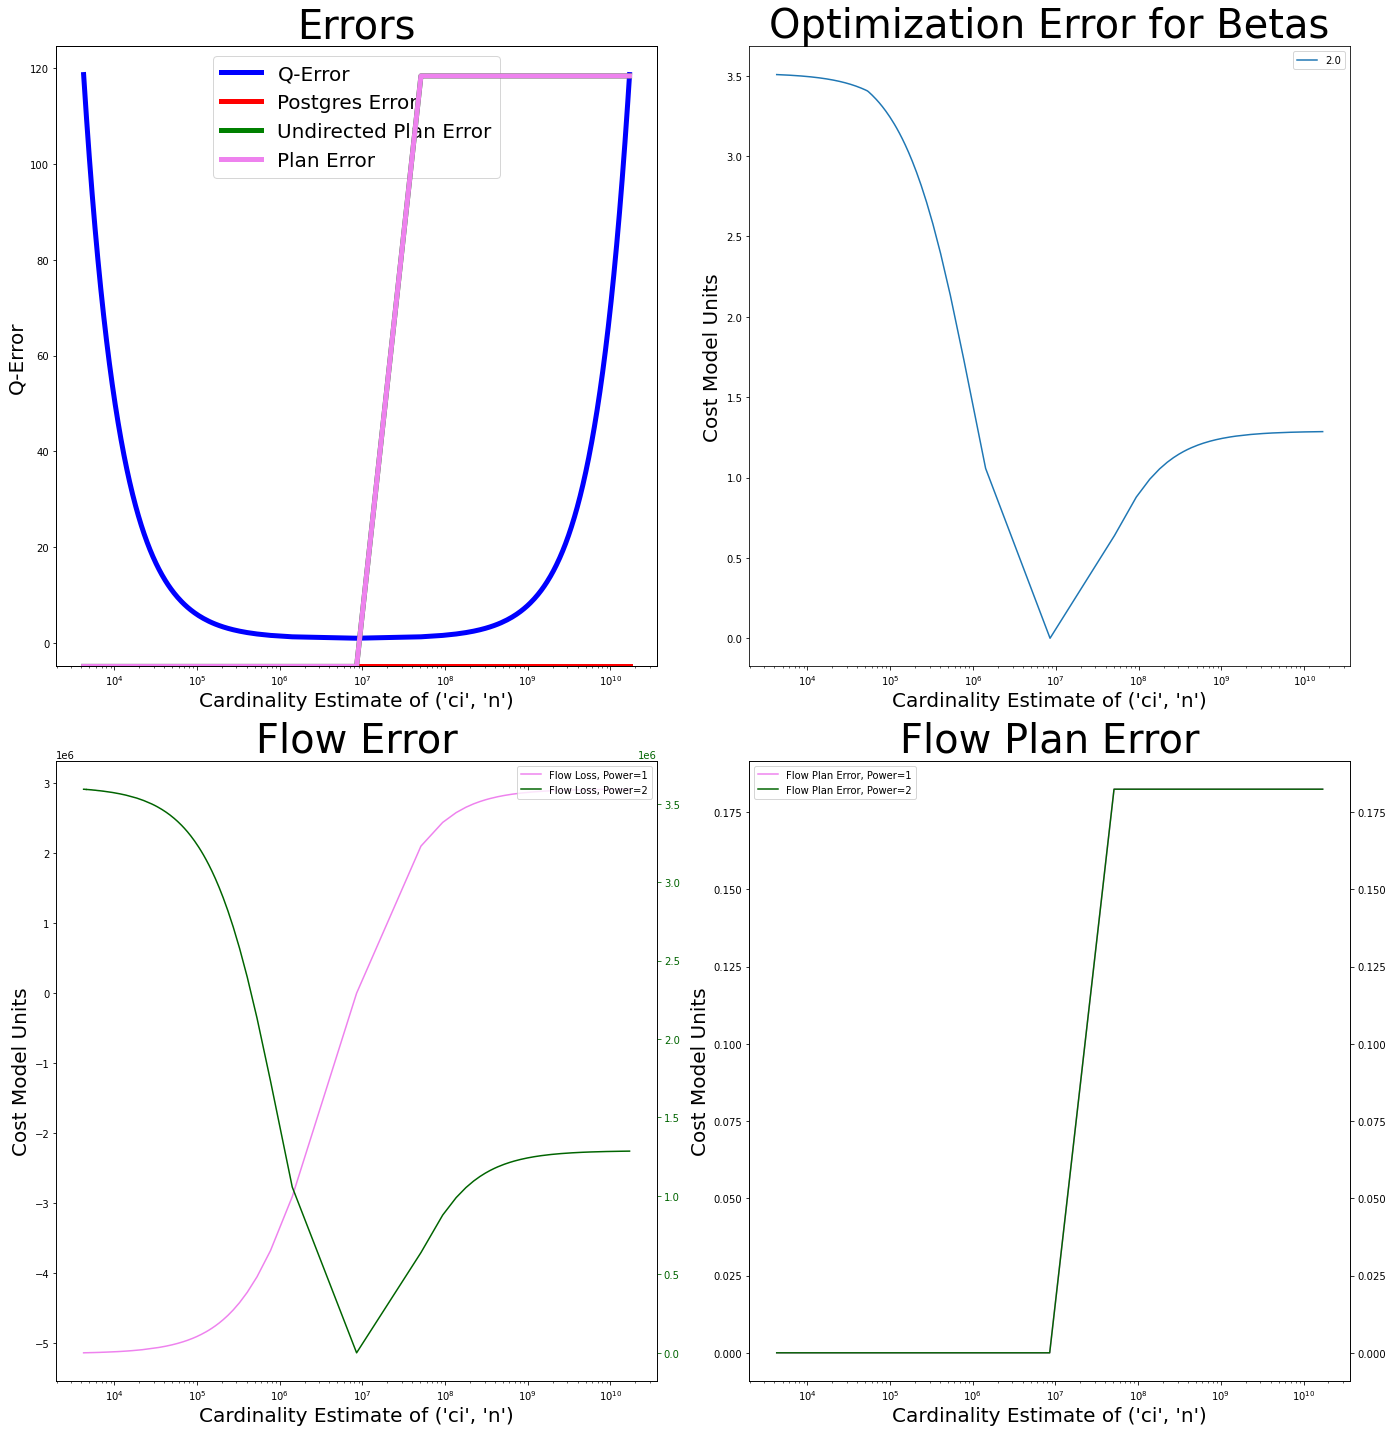

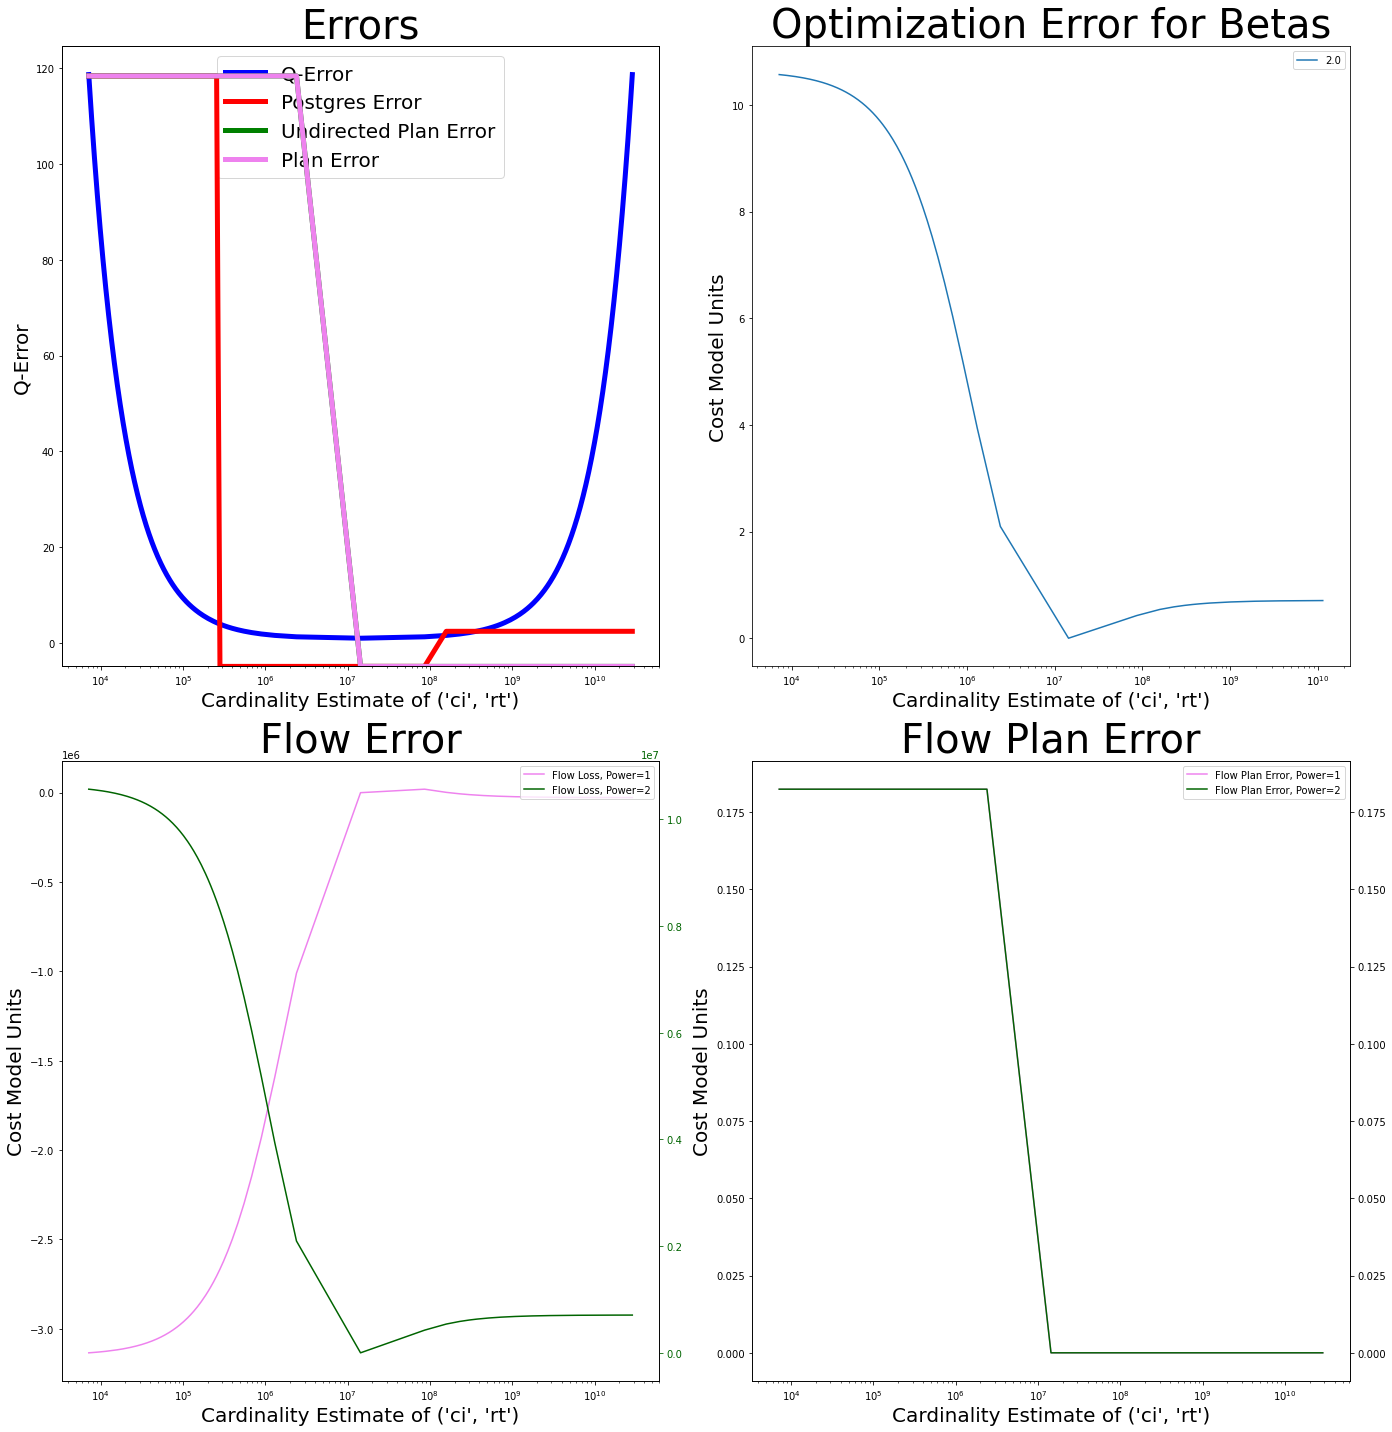

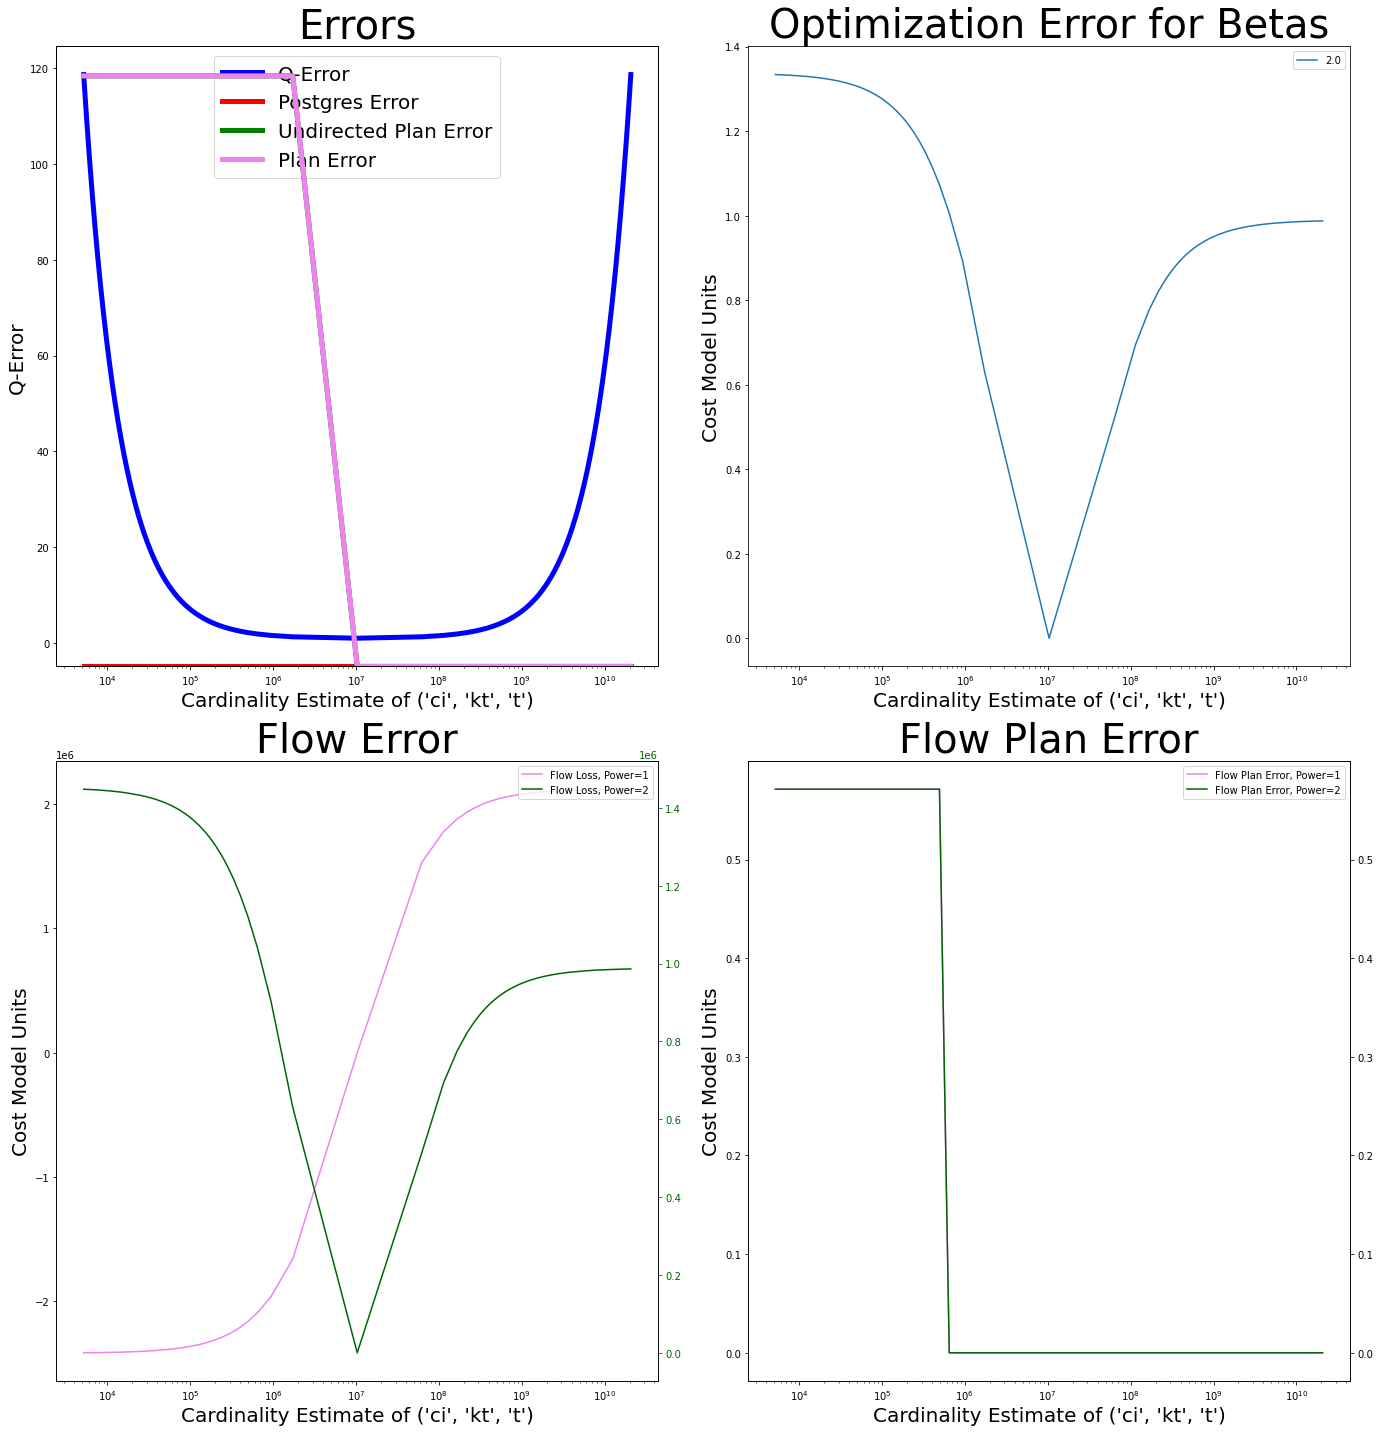

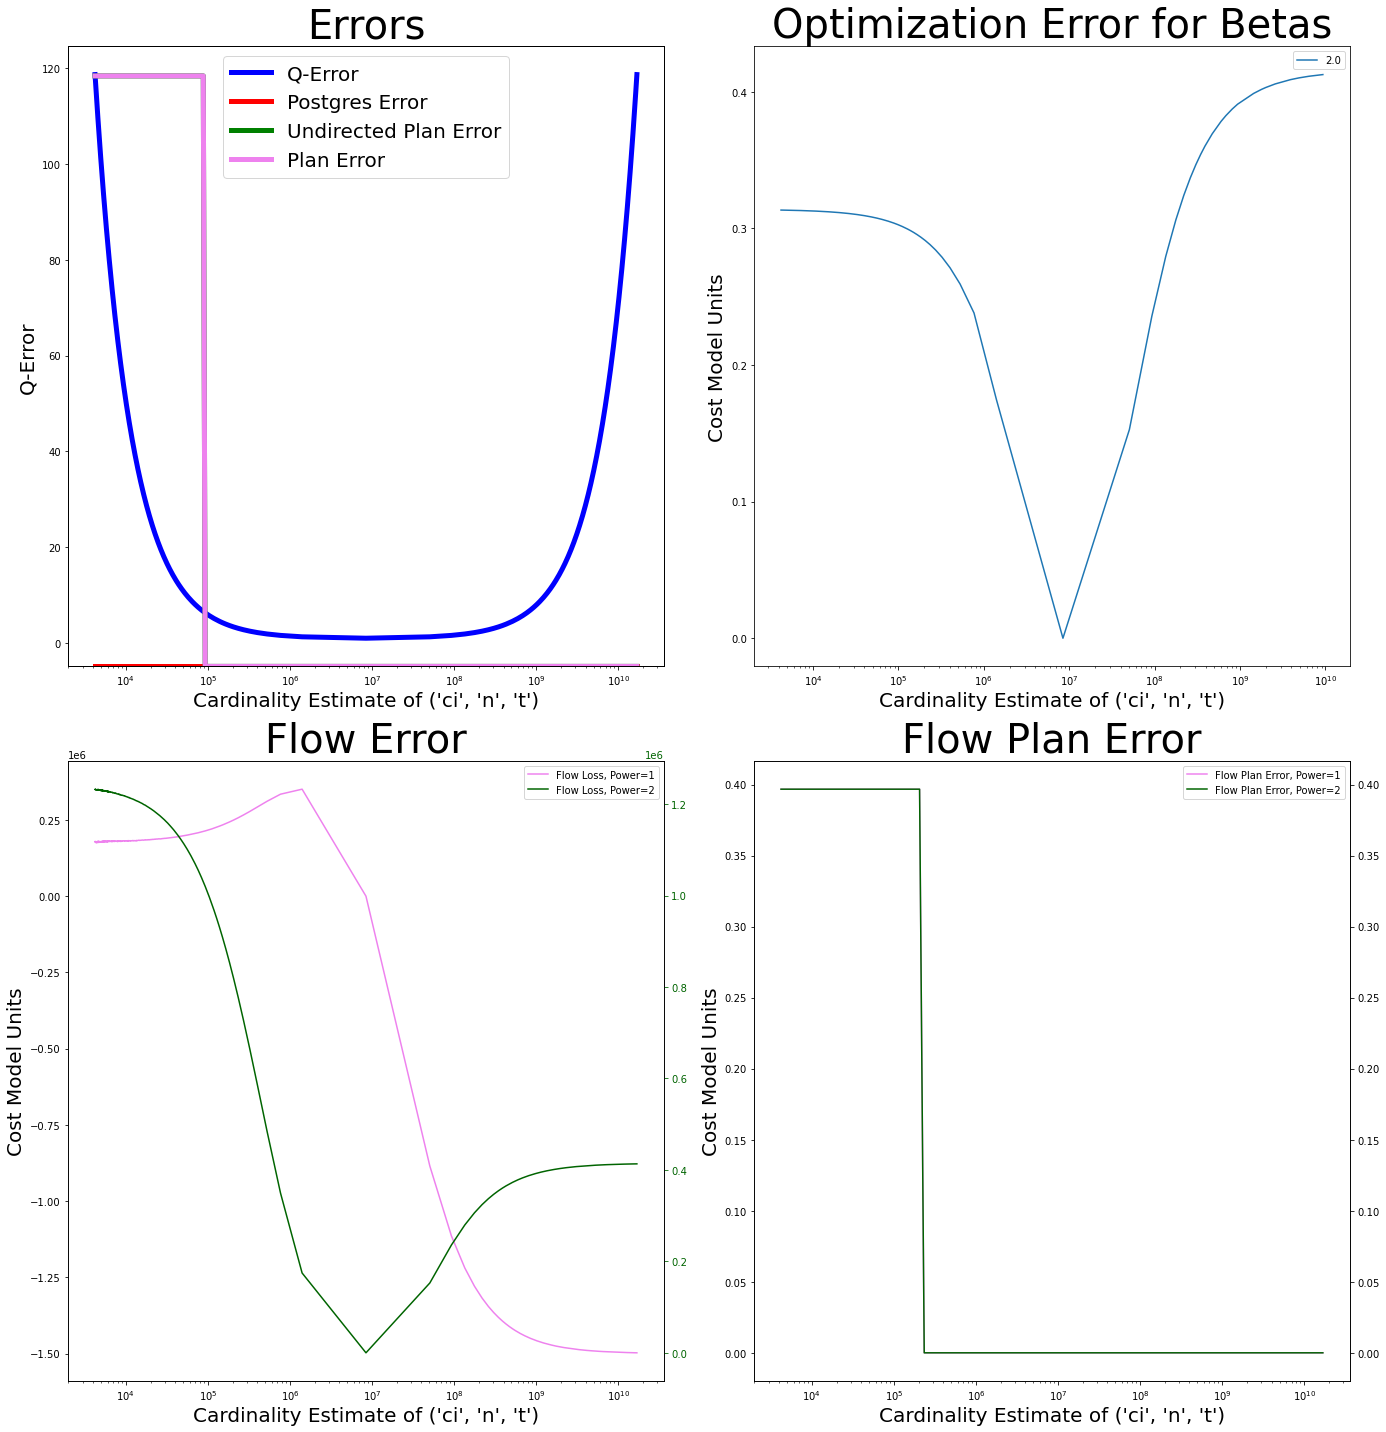

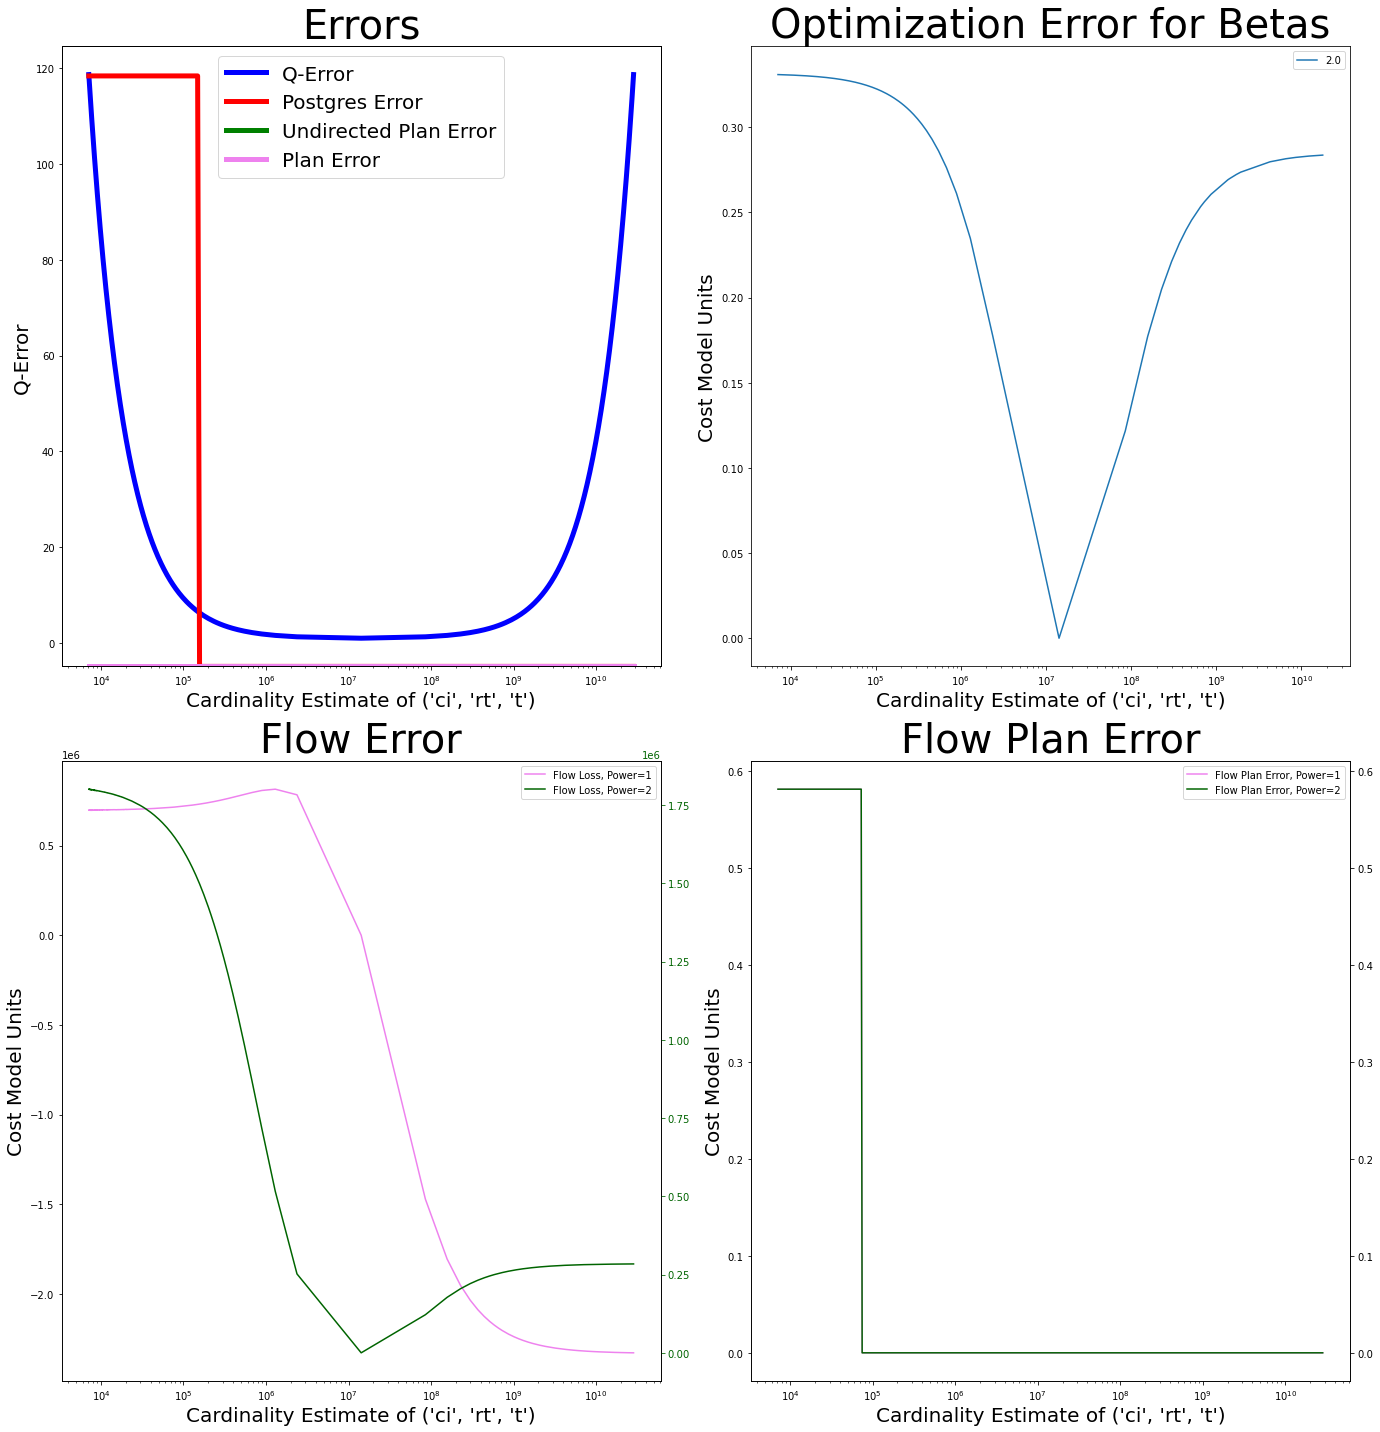

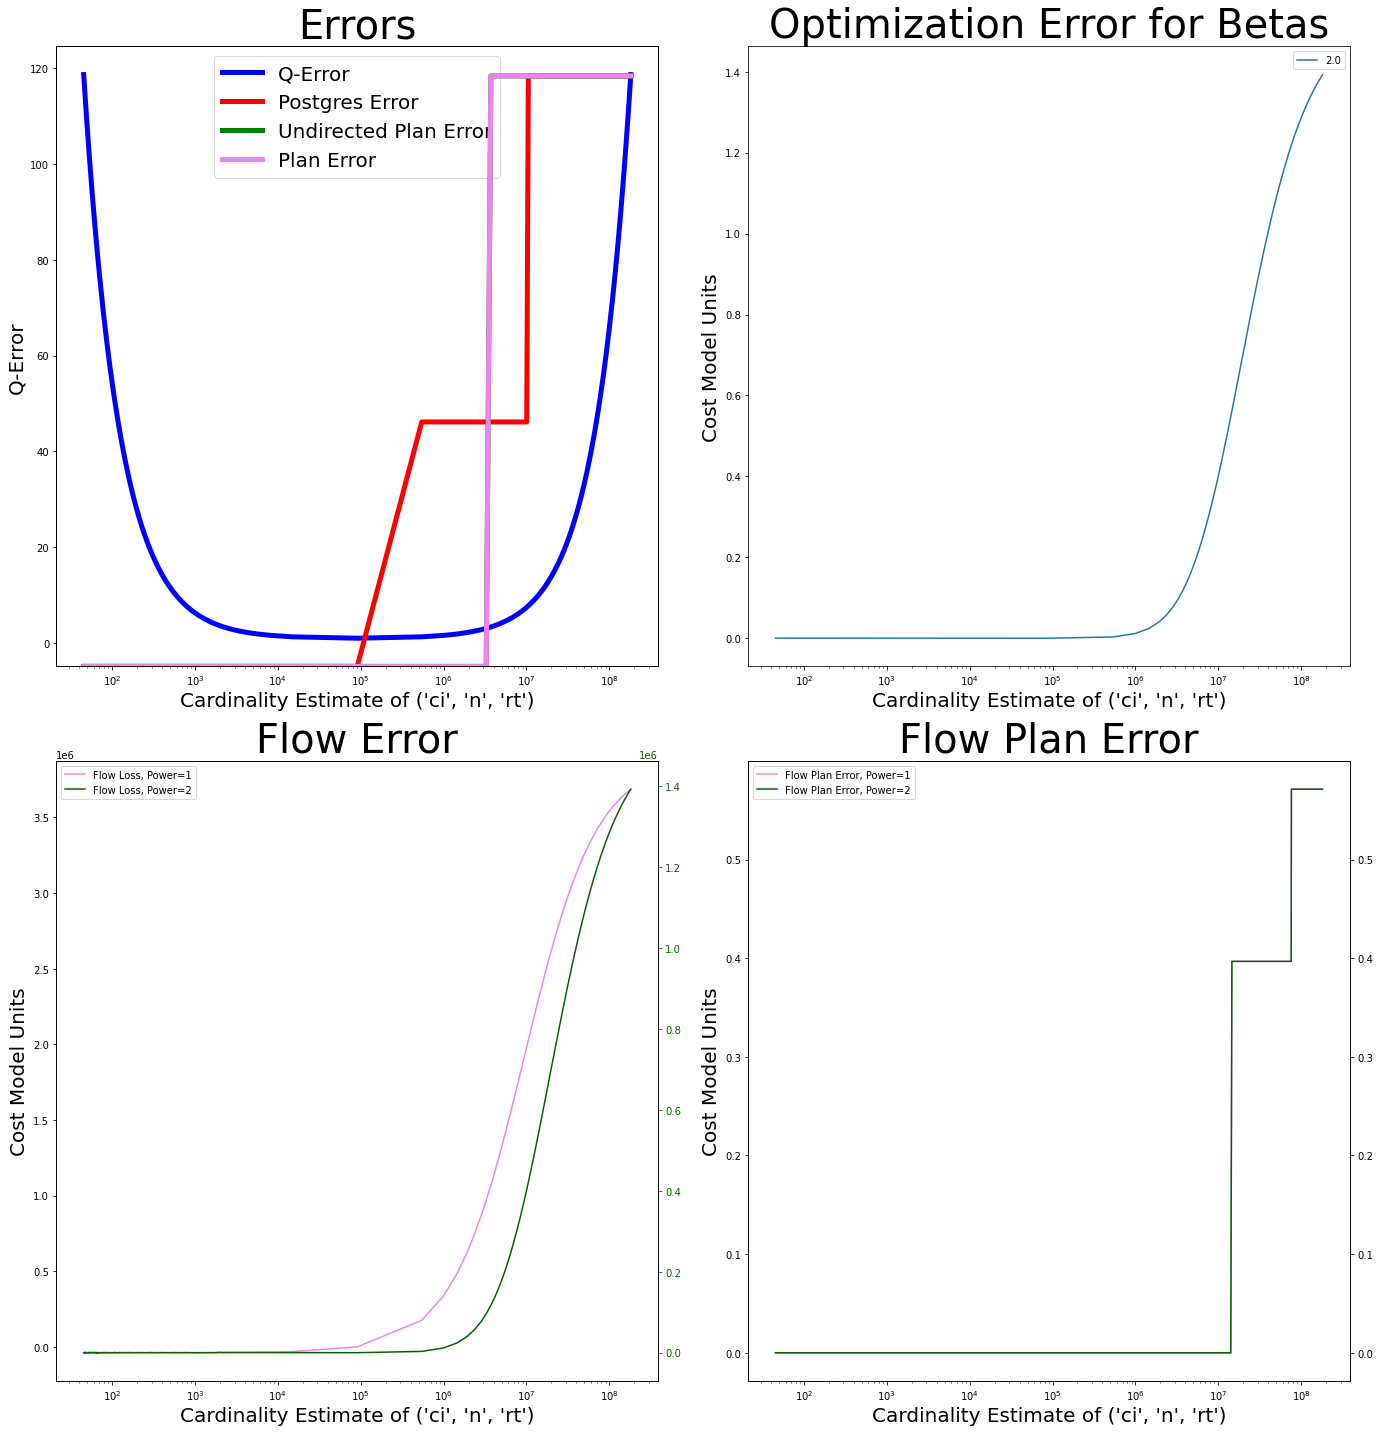

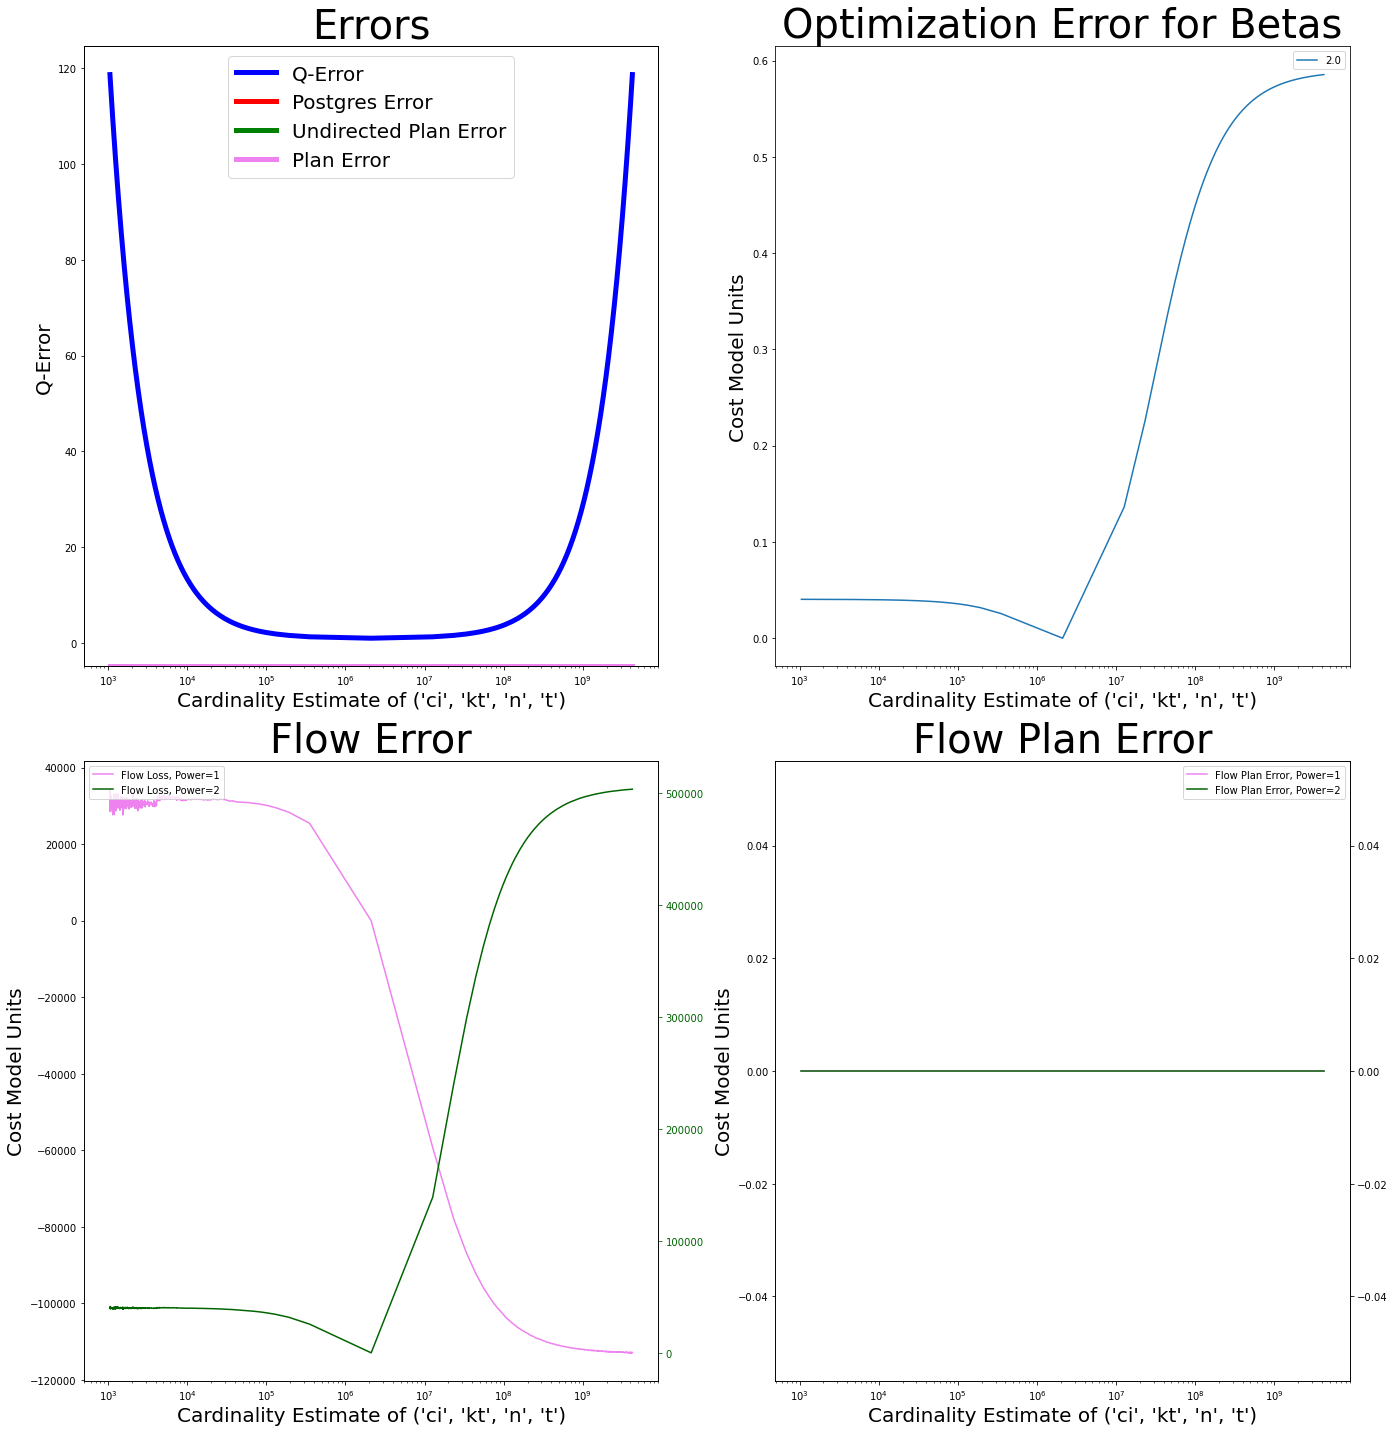

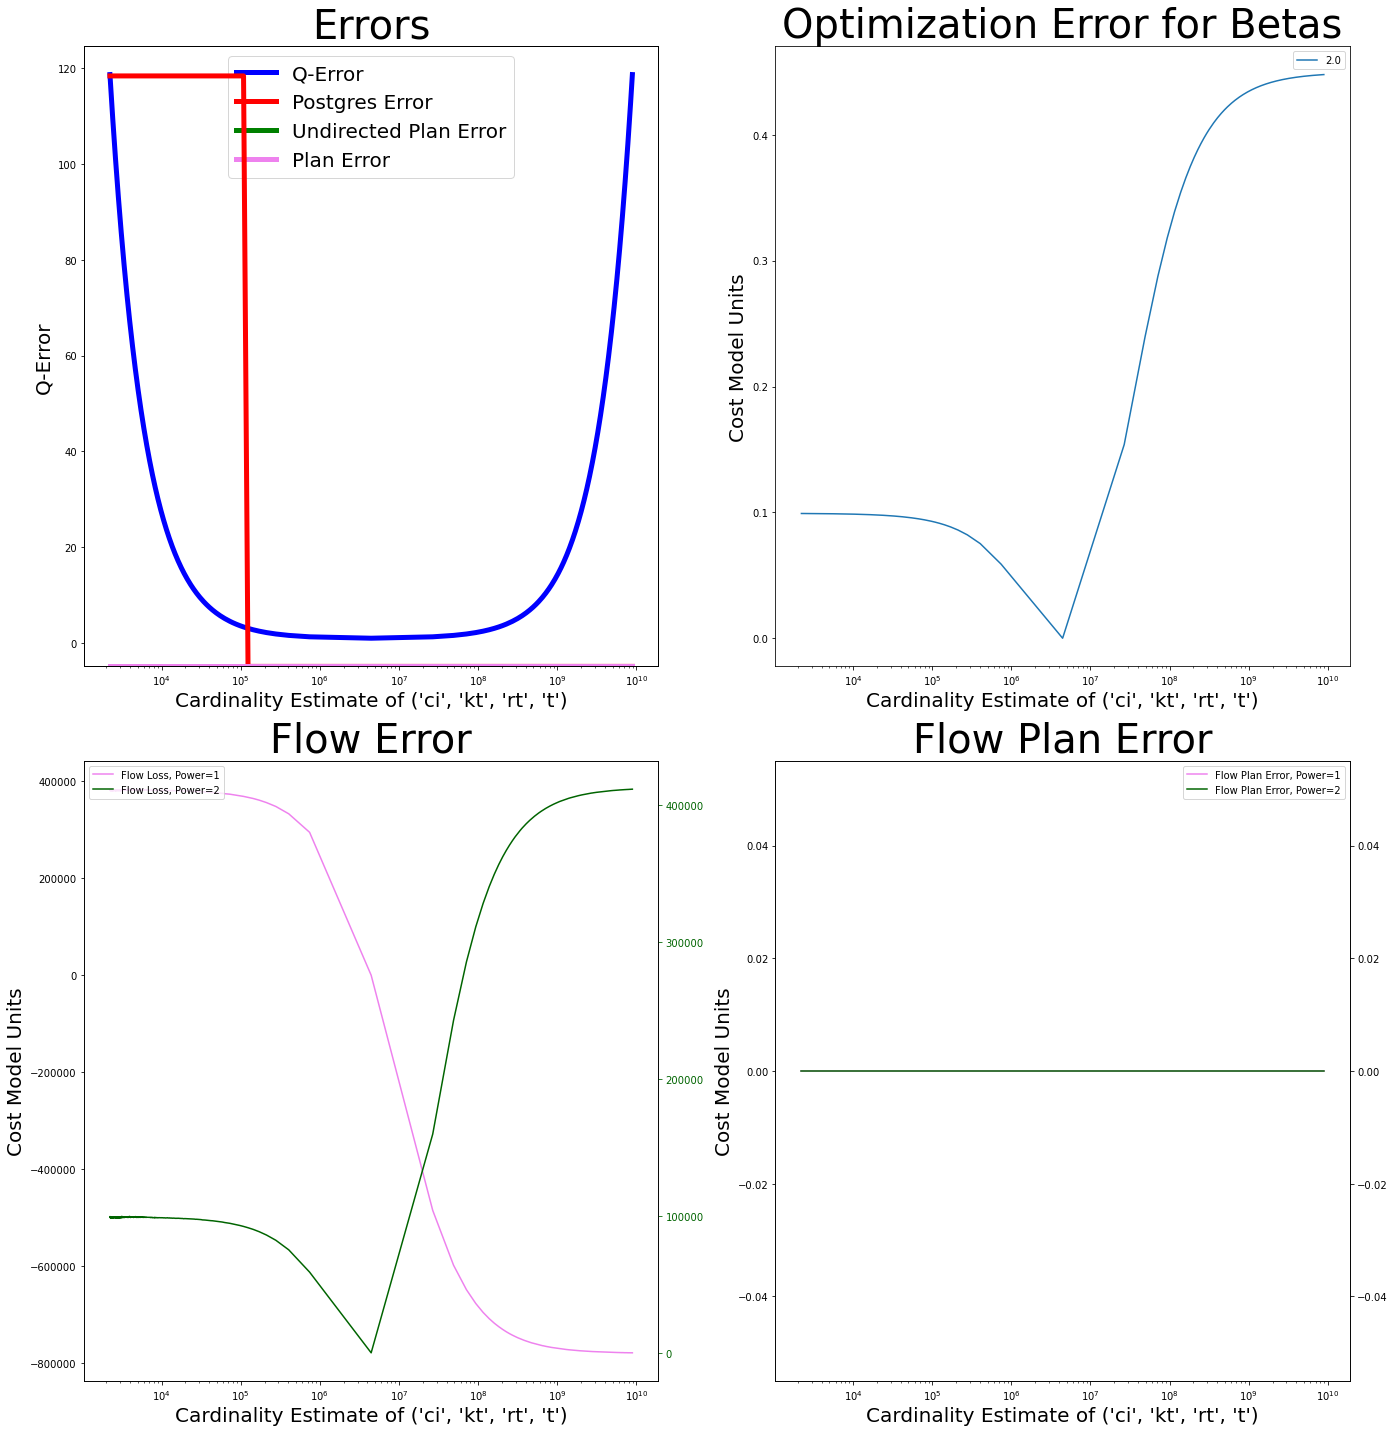

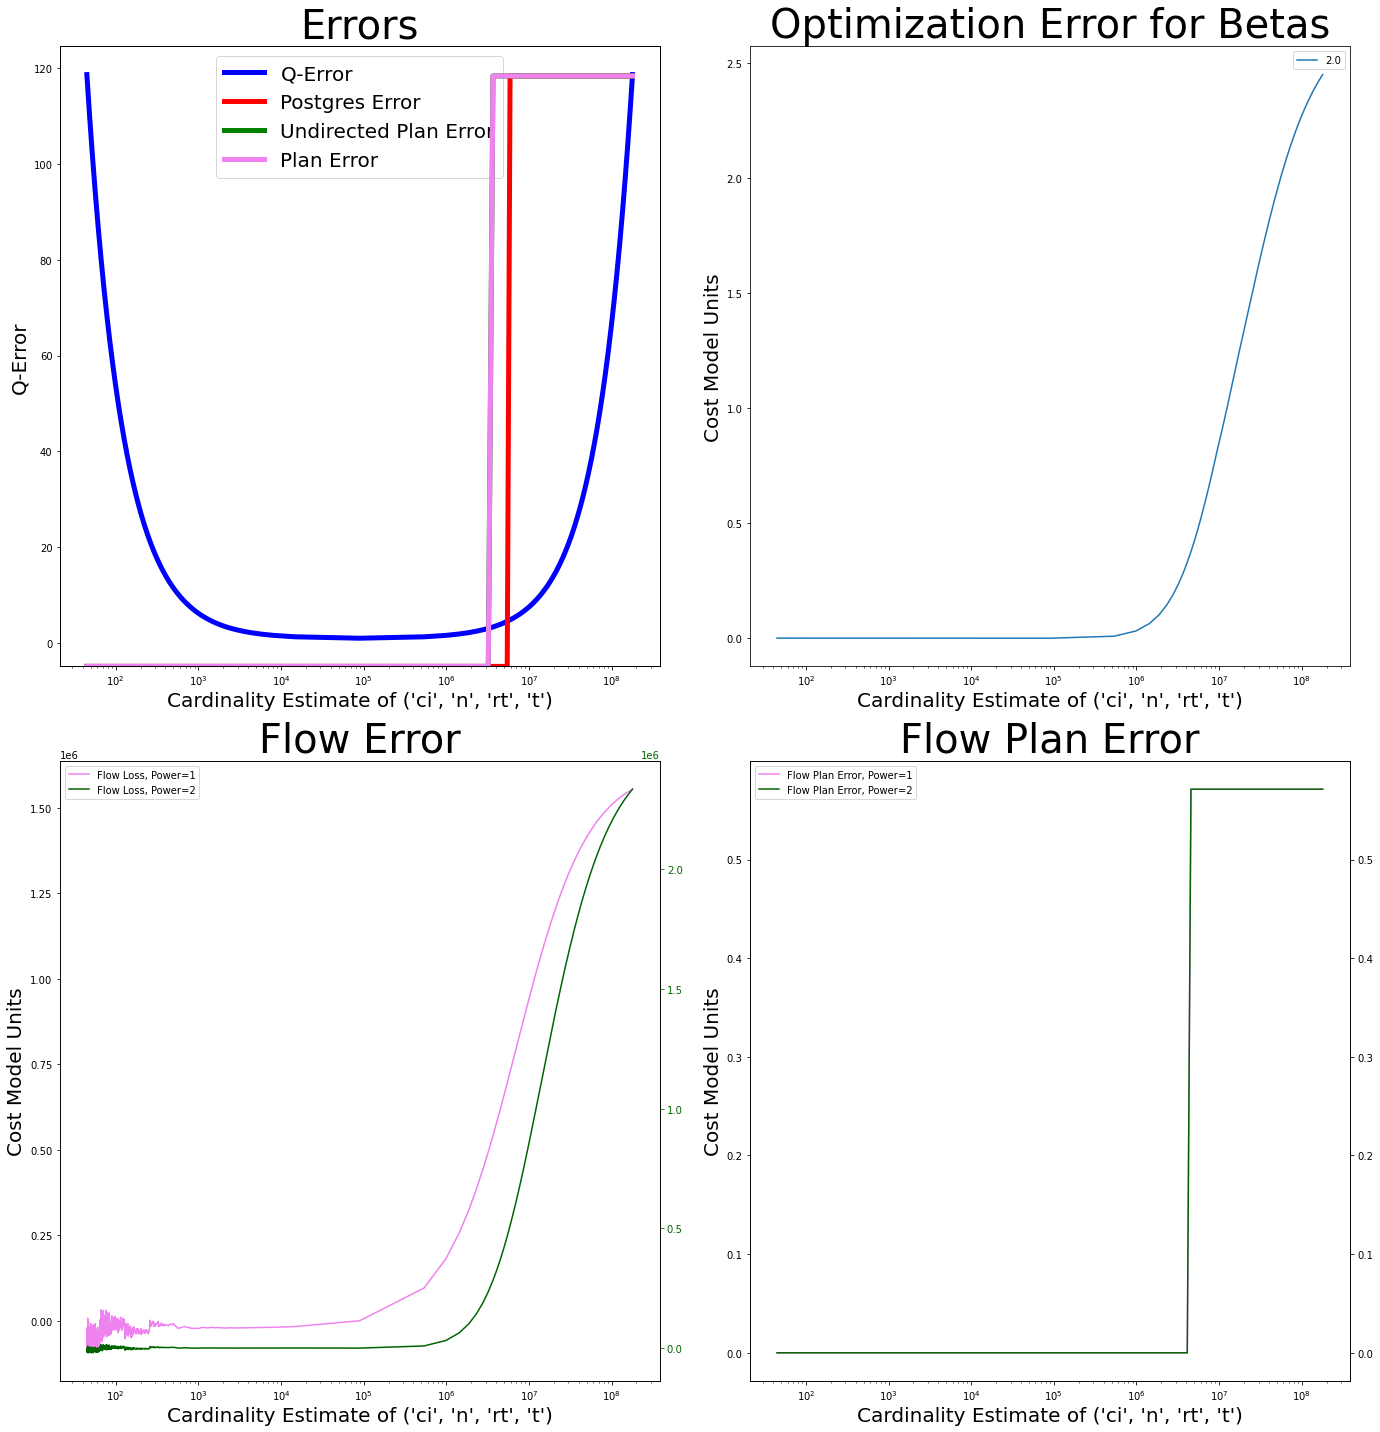

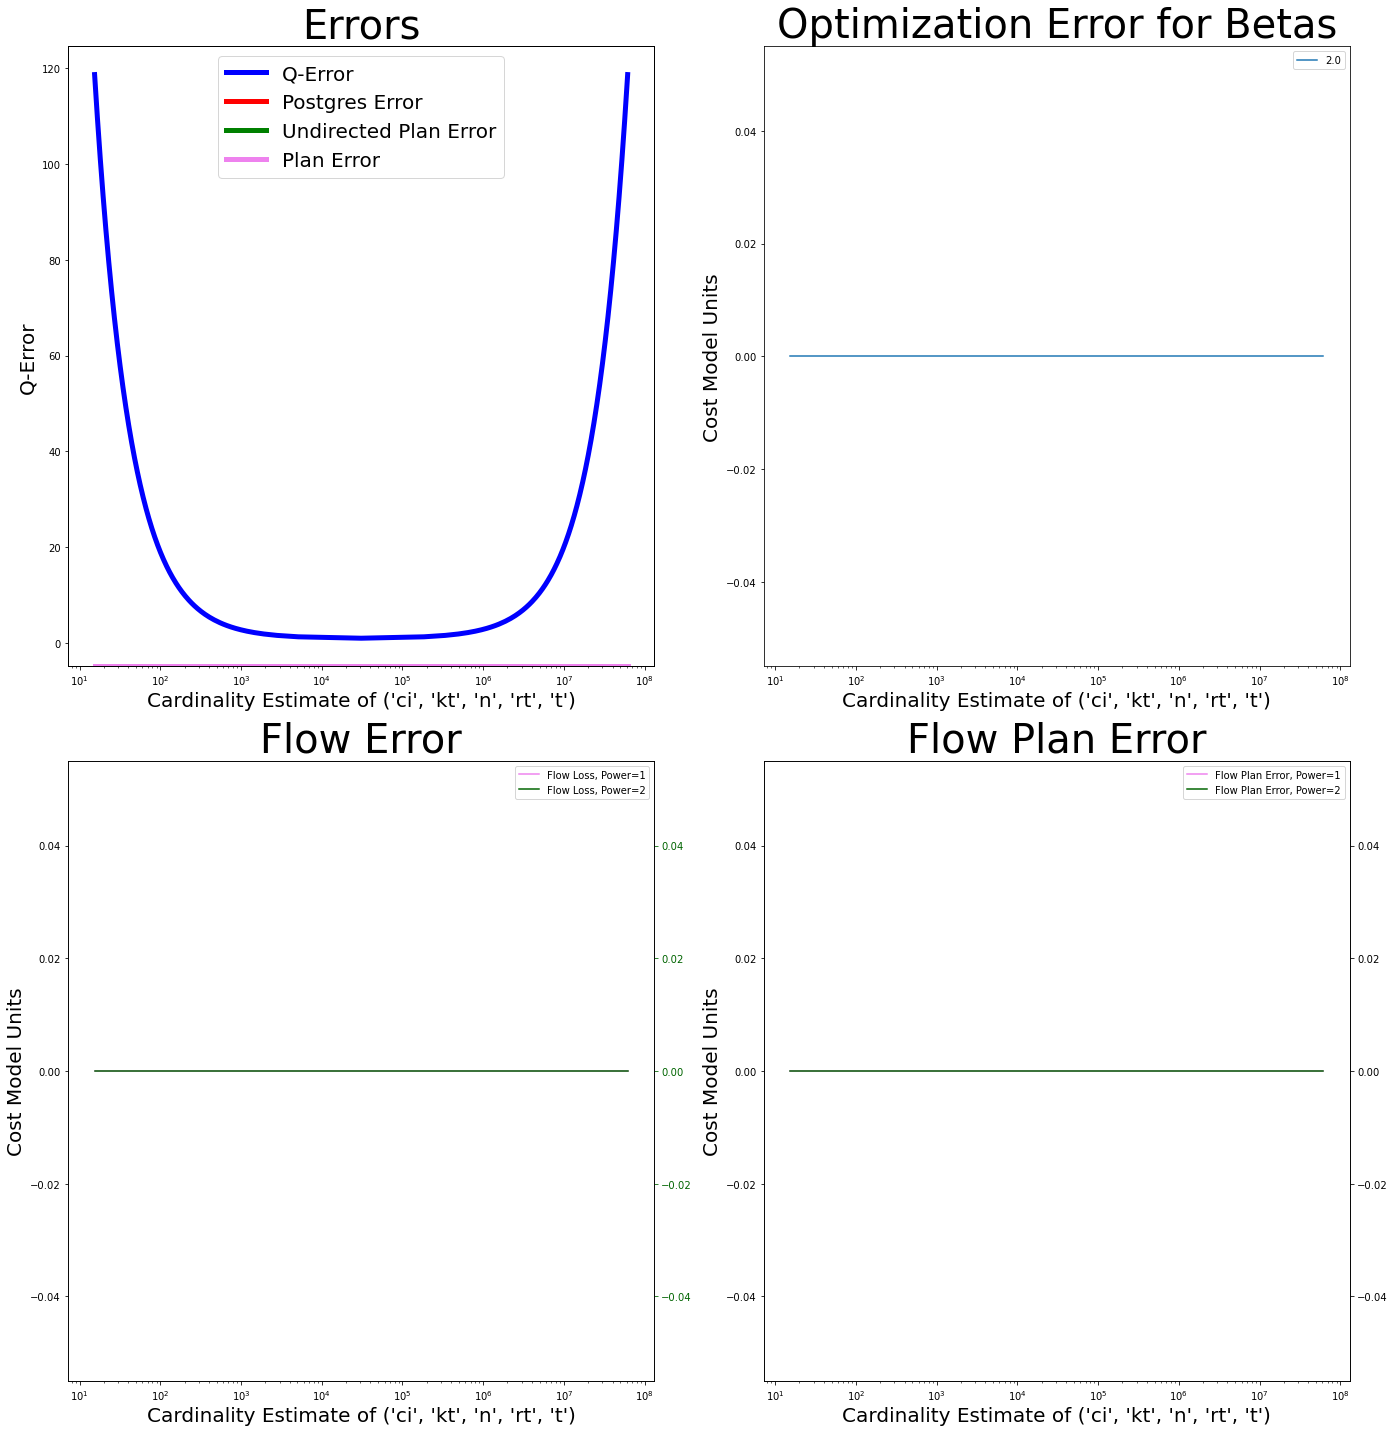

In [9]:
SAVE_DIR = "perturb_plots/" + query + "/"
print(SAVE_DIR)
make_dir(SAVE_DIR)

from itertools import cycle

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


def plot_subsets(subsets):
    def set_subplot(ax, title, xscale, xlabel, ylabel):
        ax.set_title(title,fontsize=40)
        ax.set_xscale(xscale)
        ax.set_xlabel(xlabel, fontsize=20)
        ax.set_ylabel(ylabel, fontsize=20)
    
    xs,qerrs,flow_errs,plan_errs,pg_errs,und_plan_errs,quadratic_errs,quad_flow_errs,flow_plan_errs,_ = data[subsets]
    subsets = subsets.replace("[","")
    subsets = subsets.replace("]","")

    fig, axs = plt.subplots(2,2,figsize=(20,20))
    fig.subplots_adjust(right=0.75)
    # plot 4 things, with 4 y-axis
    ax = axs[0][0]
    
    errors_list = [qerrs, pg_errs, und_plan_errs, plan_errs]
    ax_list = [ax, ax.twinx(), ax.twinx(), ax.twinx()]
    colors = ["b", "r", "g", "violet"]
    #labels = ["Q-Error", "Postgres Error", "Plan Error", "Undirected Plan Error"]
    labels = ["Q-Error", "Postgres Error", "Undirected Plan Error", "Plan Error"]

    lines = []
    for i, error in enumerate(errors_list):
        cur_ax = ax_list[i]
        sns.lineplot(xs,error,label=labels[i], ax=cur_ax, color=colors[i], linewidth=5.0, zorder=5)
        lines.append(cur_ax.get_lines()[0])
        if i != 0:
            cur_ax.get_yaxis().set_visible(False)
            cur_ax.set_ylim(0, None)
        cur_ax.get_legend().set_visible(False)
            
    set_subplot(ax, "Errors", "log", "Cardinality Estimate of "+subsets, "Q-Error")
    ax.legend(lines, [l.get_label() for l in lines], fontsize=20)

    ax = axs[0][1]    
    quad_flow_errs = list(zip(*quad_flow_errs))
    quad_flow_errs = np.array(quad_flow_errs)
    quad_flow_errs[quad_flow_errs < 0.0] = np.nan
    #quad_flow_errs = np.ma.masked_where(quad_flow_errs < 0.0, quad_flow_errs)
    
    #colors = "bgrcmykw"
    #cycol = cycle(colors)
    lines = []
    labels = []
    

    NUM_COLORS = 11
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    #ax.set_prop_cycle(cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]))
    
    for i, beta in enumerate(QUAD_BETAS):
        cur_ax = ax
        sns.lineplot(xs,quad_flow_errs[i],label=beta, ax=cur_ax)
        
#         cur_ax = ax.twinx()
#         cur_ax.get_yaxis().set_visible(False)
#         sns.lineplot(xs,quad_flow_errs[i],label=beta, ax=cur_ax, color=colors[i])
#         line, lab = cur_ax.get_legend_handles_labels()
#         lines.append(line[0])
#         labels.append(lab[0])
        #cur_ax.get_legend().set_visible(False)

#     ax.get_yaxis().set_visible(False)
#     ax.legend(lines, labels, loc=0)

    set_subplot(ax, "Optimization Error for Betas", "log", "Cardinality Estimate of "+subsets, "Cost Model Units")
    
    ax = axs[1][0]
    flow_errs = list(zip(*flow_errs))
    #flow_plan_errs = list(zip(*flow_plan_errs))   
    ax2 = ax.twinx()
    lp = sns.lineplot(xs,flow_errs[0],label="Flow Loss, Power=1", ax=ax, color="violet")
    lp = sns.lineplot(xs,flow_errs[1],label="Flow Loss, Power=2", ax=ax2, color="darkgreen")

    set_subplot(ax, "Flow Error", "log", "Cardinality Estimate of "+subsets, "Cost Model Units")
    ax2.yaxis.label.set_color("darkgreen")
    ax2.tick_params(axis='y', colors="darkgreen")
    ax.get_legend().set_visible(False)
    ax2.get_legend().set_visible(False)


    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax = axs[1][1]
    #flow_errs = list(zip(*flow_errs))
    flow_plan_errs = list(zip(*flow_plan_errs))   
    ax2 = ax.twinx()
    lp = sns.lineplot(xs,flow_plan_errs[0],label="Flow Plan Error, Power=1", ax=ax, color="violet")
    lp = sns.lineplot(xs,flow_plan_errs[1],label="Flow Plan Error, Power=2", ax=ax2, color="darkgreen")
    ax.get_legend().set_visible(False)
    ax2.get_legend().set_visible(False)



    set_subplot(ax, "Flow Plan Error", "log", "Cardinality Estimate of "+subsets, "Cost Model Units")
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    subset_name = subsets
    plt.tight_layout()
    plt.savefig(SAVE_DIR + "errors-" + str(subset_name) + ".png")
    plt.show()
    
print("num subsets: ", len(data))
for subset in data:
    plot_subsets(subset)